In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from contrastive_phenotypes.src.ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.cross_decomposition import CCA
from sklearn.metrics import mean_absolute_percentage_error



/storage/store2/work/mrenaudi/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = '.'
train_ratio = 1.0
test_ratio = 0.3

## Functions to plot


In [8]:
def plot_scores(ridge, cca, model, targets, model_and_ridge=None):
    ridge = ridge.assign(model="Ridge")
    cca = cca.assign(model="CCA")
    model = model.assign(model="Contrastive learning")
    if model_and_ridge is not None:
        model_and_ridge = model_and_ridge.assign(model="Contrastive learning and Ridge regression")

    # Concatenate results
    if model_and_ridge is not None and not model_and_ridge.empty:
        primary_model = model_and_ridge
        all_results = pd.concat([ridge, cca, model, model_and_ridge], ignore_index=True)
    else:
        primary_model = model
        all_results = pd.concat([ridge, cca, model], ignore_index=True)

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model_name, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():
                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model_name, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Filter results for the primary model to determine ranking
    primary_results = results_df[results_df["model"] == primary_model["model"].iloc[0]]

    # Rank targets based on Spearman and MAPE for the primary model
    target_ranking = (
        primary_results[["target", "spearman_corr", "mape"]]
        .assign(
            spearman_corr_rank=lambda df: df["spearman_corr"].rank(ascending=False),
            mape_rank=lambda df: df["mape"].rank(ascending=True),
        )
        .sort_values(by=["spearman_corr_rank", "mape_rank"])
    )

    sorted_targets_by_corr = target_ranking["target"].tolist()
    sorted_targets_by_mape = target_ranking.sort_values(by="mape_rank")["target"].tolist()

    # Compute average Spearman and MAPE per model
    avg_metrics = results_df.groupby("model")[["spearman_corr", "mape"]].mean()

    # Define color palette for consistent colors
    palette = sns.color_palette("tab10")
    model_colors = dict(zip(results_df["model"].unique(), palette))

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette=model_colors,
        order=sorted_targets_by_corr,  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add average Spearman dashed lines
    for model_name, avg_value in avg_metrics["spearman_corr"].items():
        axes[0].axhline(avg_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette=model_colors,
        order=sorted_targets_by_mape,  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add average MAPE dashed lines
    for model_name, avg_value in avg_metrics["mape"].items():
        axes[1].axhline(avg_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    axes[1].set_ylim(0, 150)

    # Update the x-axis labels for better readability
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Add the average score information to the legend
    handles, labels = axes[0].get_legend_handles_labels()
    avg_labels = [
        f"{label} (Avg Spearman: {avg_metrics.loc[label, 'spearman_corr']:.2f}, "
        f"Avg MAPE: {avg_metrics.loc[label, 'mape']:.2f}%)"
        for label in labels
    ]
    fig.legend(
        handles,
        avg_labels,
        title="Model",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=4,  # Number of columns in the legend
        frameon=False,
    )

    # Remove individual legends from the subplots
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.show()


In [9]:
def plot_median_scores(ridge, cca, model, targets, model_and_ridge=None):
    ridge = ridge.assign(model="Ridge")
    cca = cca.assign(model="CCA")
    model = model.assign(model="Contrastive learning")
    if model_and_ridge is not None:
        model_and_ridge = model_and_ridge.assign(model="Contrastive learning and Ridge regression")

    # Concatenate results
    if model_and_ridge is not None and not model_and_ridge.empty:
        primary_model = model_and_ridge
        all_results = pd.concat([ridge, cca, model, model_and_ridge], ignore_index=True)
    else:
        primary_model = model
        all_results = pd.concat([ridge, cca, model], ignore_index=True)

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model_name, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():
                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model_name, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Filter results for the primary model to determine ranking
    primary_results = results_df[results_df["model"] == primary_model["model"].iloc[0]]

    # Rank targets based on Spearman and MAPE for the primary model
    target_ranking = (
        primary_results[["target", "spearman_corr", "mape"]]
        .assign(
            spearman_corr_rank=lambda df: df["spearman_corr"].rank(ascending=False),
            mape_rank=lambda df: df["mape"].rank(ascending=True),
        )
        .sort_values(by=["spearman_corr_rank", "mape_rank"])
    )

    sorted_targets_by_corr = target_ranking["target"].tolist()
    sorted_targets_by_mape = target_ranking.sort_values(by="mape_rank")["target"].tolist()

    # Compute median Spearman and MAPE per model
    median_metrics = results_df.groupby("model")[["spearman_corr", "mape"]].median()

    # Define color palette for consistent colors
    palette = sns.color_palette("tab10")
    model_colors = dict(zip(results_df["model"].unique(), palette))

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette=model_colors,
        order=sorted_targets_by_corr,  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add median Spearman dashed lines
    for model_name, median_value in median_metrics["spearman_corr"].items():
        axes[0].axhline(median_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette=model_colors,
        order=sorted_targets_by_mape,  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add median MAPE dashed lines
    for model_name, median_value in median_metrics["mape"].items():
        axes[1].axhline(median_value, color=model_colors[model_name], linestyle="--", linewidth=1.2)

    # Limit y-axis of MAPE plot to 100
    axes[1].set_ylim(0, 150)

    # Update the x-axis labels for better readability
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Add the median score information to the legend
    handles, labels = axes[0].get_legend_handles_labels()
    median_labels = [
        f"{label} (Median Spearman: {median_metrics.loc[label, 'spearman_corr']:.2f}, "
        f"Median MAPE: {median_metrics.loc[label, 'mape']:.2f}%)"
        for label in labels
    ]
    fig.legend(
        handles,
        median_labels,
        title="Model",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=4,  # Number of columns in the legend
        frameon=False,
    )

    # Remove individual legends from the subplots
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.show()


## Preparing data for CV Ridge regression and CCA

In [10]:
def prepare_data(dataset_path, targets):
    dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

    n_sub = len(dataset)
    indices = np.arange(n_sub)

    train_size = int(n_sub * (1 - test_ratio) * train_ratio)
    test_size = int(test_ratio * n_sub)
    run_size = test_size + train_size

    random_state = np.random.RandomState(seed=42)
    run_indices = random_state.choice(indices, run_size, replace=False)
    train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
    X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
    y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
    X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
    X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
    y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()

    return X_train, y_train, X_test, y_test
        

In [11]:
def ridge_pred(X_train, y_train, X_test, y_test, targets, random_seed = 42) :
    
    ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2", random_state = random_seed)

    pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

    fitted_pipe = pipe_ridge.fit(X_train, y_train)

    y_train_pred = fitted_pipe.predict(X_train)
    y_test_pred = fitted_pipe.predict(X_test)

    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    # Combine train and test results into a single DataFrame
    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

In [12]:
def cca_pred(X_train, y_train, X_test, y_test, targets):
    n_components = min(len(targets), X_train.shape[1])  
    pipe_cca = Pipeline([
        ('scaler', StandardScaler()),  
        ('cca', CCA(n_components=n_components))
    ])

    pipe_cca.fit(X_train, y_train)
    cca_model = pipe_cca.named_steps['cca']

    y_train_pred = cca_model.predict(X_train)
    y_test_pred = cca_model.predict(X_test)
    
    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)


## Predicting residuals

### Tried to implement a custom scorer, but the end performance is the same when using an R2 scorer

In [78]:
# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")
# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]



# Extract original and predicted values for train and test sets
pred_target_train = train_data[pred_cols].values
true_target_train = train_data[target_cols].values
pred_target_test = test_data[pred_cols].values
true_target_test = test_data[target_cols].values

# Define residuals
residuals_train = true_target_train - pred_target_train  # Original targets - predicted values

# # Calculate residual variance for each target
# residual_variances = np.var(residuals_train, axis=0)

# # Create weights inversely proportional to the residual variance
# weights = 1 / (residual_variances + 1e-6)  # Add a small epsilon to prevent division by zero
# weights_normalized = weights / np.sum(weights)  # Normalize to sum to 1

# # Custom scorer combining Spearman correlation and MAPE with weights
# def custom_scorer_weighted(y_true, y_pred):
#     spearman_corrs = np.array([
#         spearmanr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])
#     ])
#     mape = mean_absolute_percentage_error(y_true, y_pred)
#     weighted_spearman = np.sum(weights_normalized * spearman_corrs)
#     return (1 - weighted_spearman) #+ mape

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a Ridge model separately
for i, target in enumerate(target_cols):
    # Define the Ridge regression model
    ridge_model = Ridge()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "alpha": [0.1, 1.0, 10.0, 100.0]  # Regularization strength
    }
    grid_search_ridge = GridSearchCV(
        ridge_model,
        param_grid=param_grid,
        cv=5,
        scoring= "r2"#make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to residuals for the current target
    grid_search_ridge.fit(true_target_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_ridge.predict(true_target_train)
    residuals_test_pred = grid_search_ridge.predict(true_target_test)

    # Correct predictions
    y_train_pred_target = pred_target_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = pred_target_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(true_target_train[:, i], y_train_pred[:, i])[0] for i in range(true_target_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(true_target_test[:, i], y_test_pred[:, i])[0] for i in range(true_target_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(true_target_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(true_target_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")



Train Spearman: 0.9280564393578978, Train MAPE: 0.05911413926389688
Test Spearman: 0.7609566862902853, Test MAPE: 0.14267353689765802


In [79]:
train_df = pd.DataFrame(true_target_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(true_target_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

model_and_ridge =  pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

## Performance comparison

### Here, using auxiliary targets to train CCA and Ridge too, but it can be changed

/tmp/ipykernel_2969458/2487453533.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


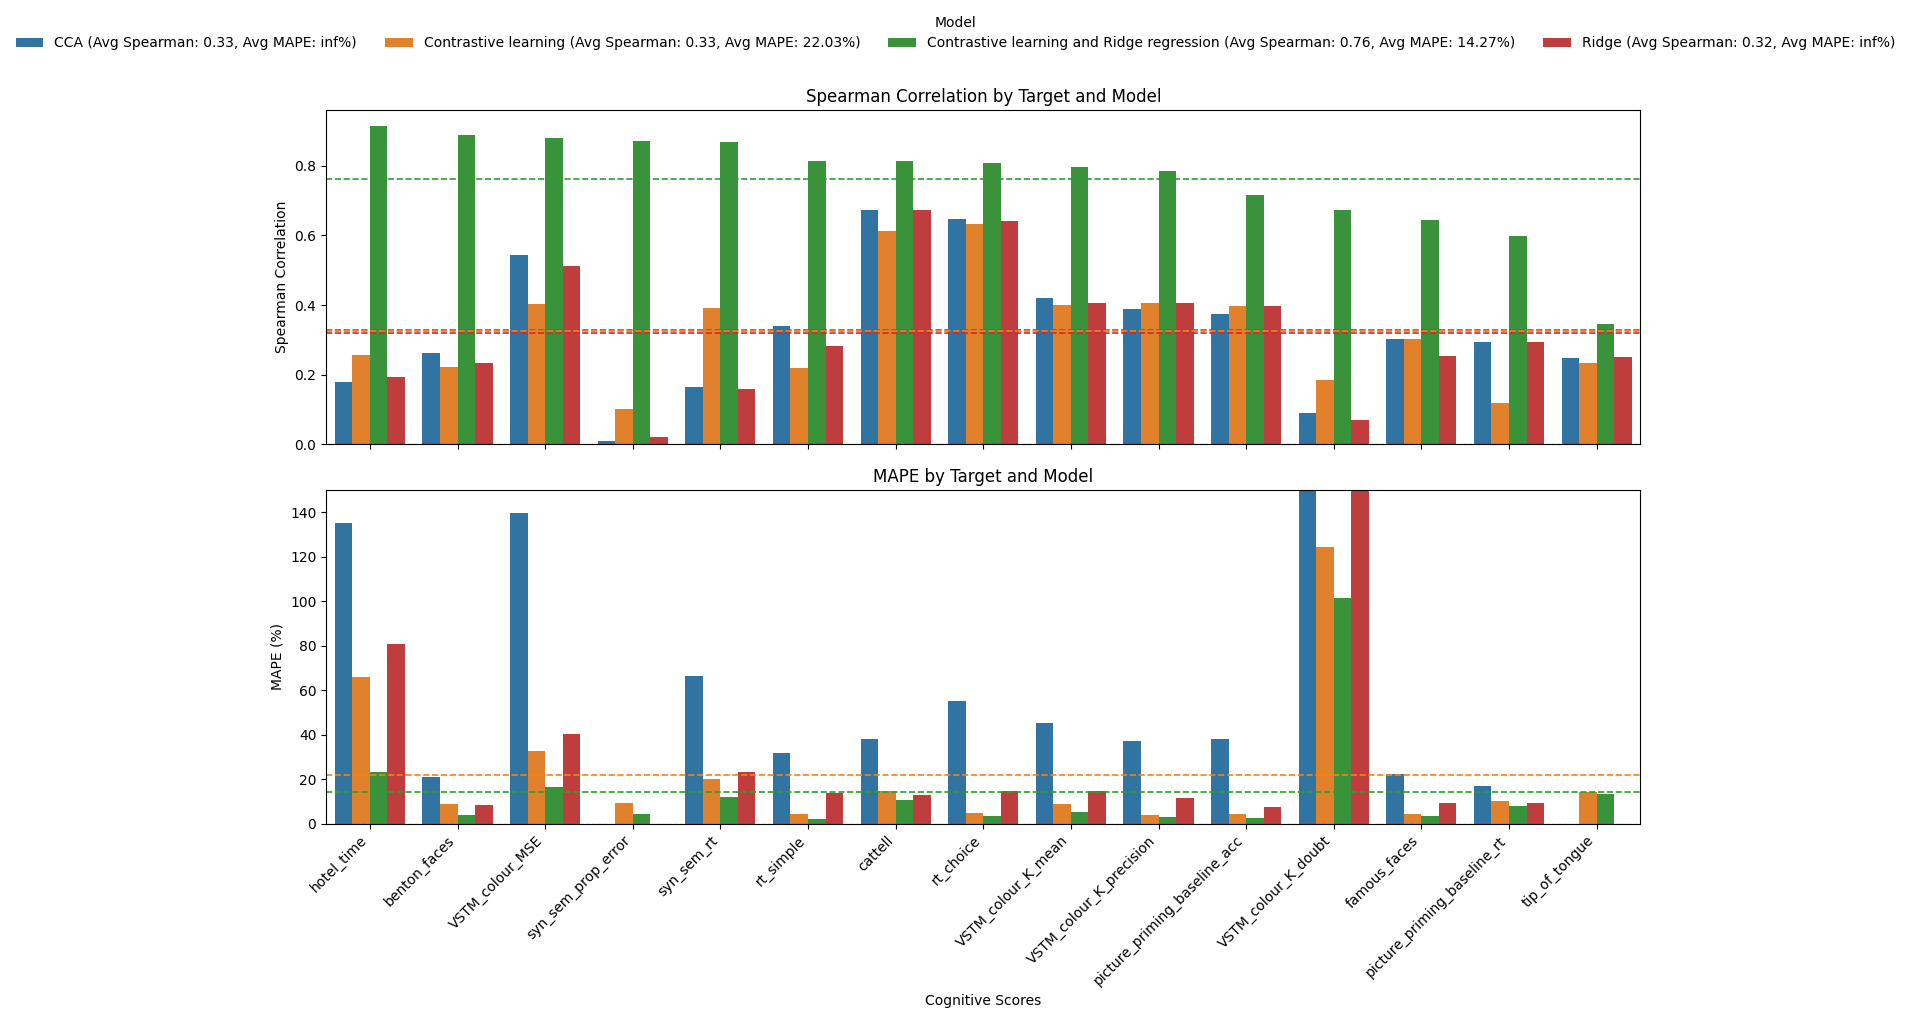

/tmp/ipykernel_2969458/3354203737.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


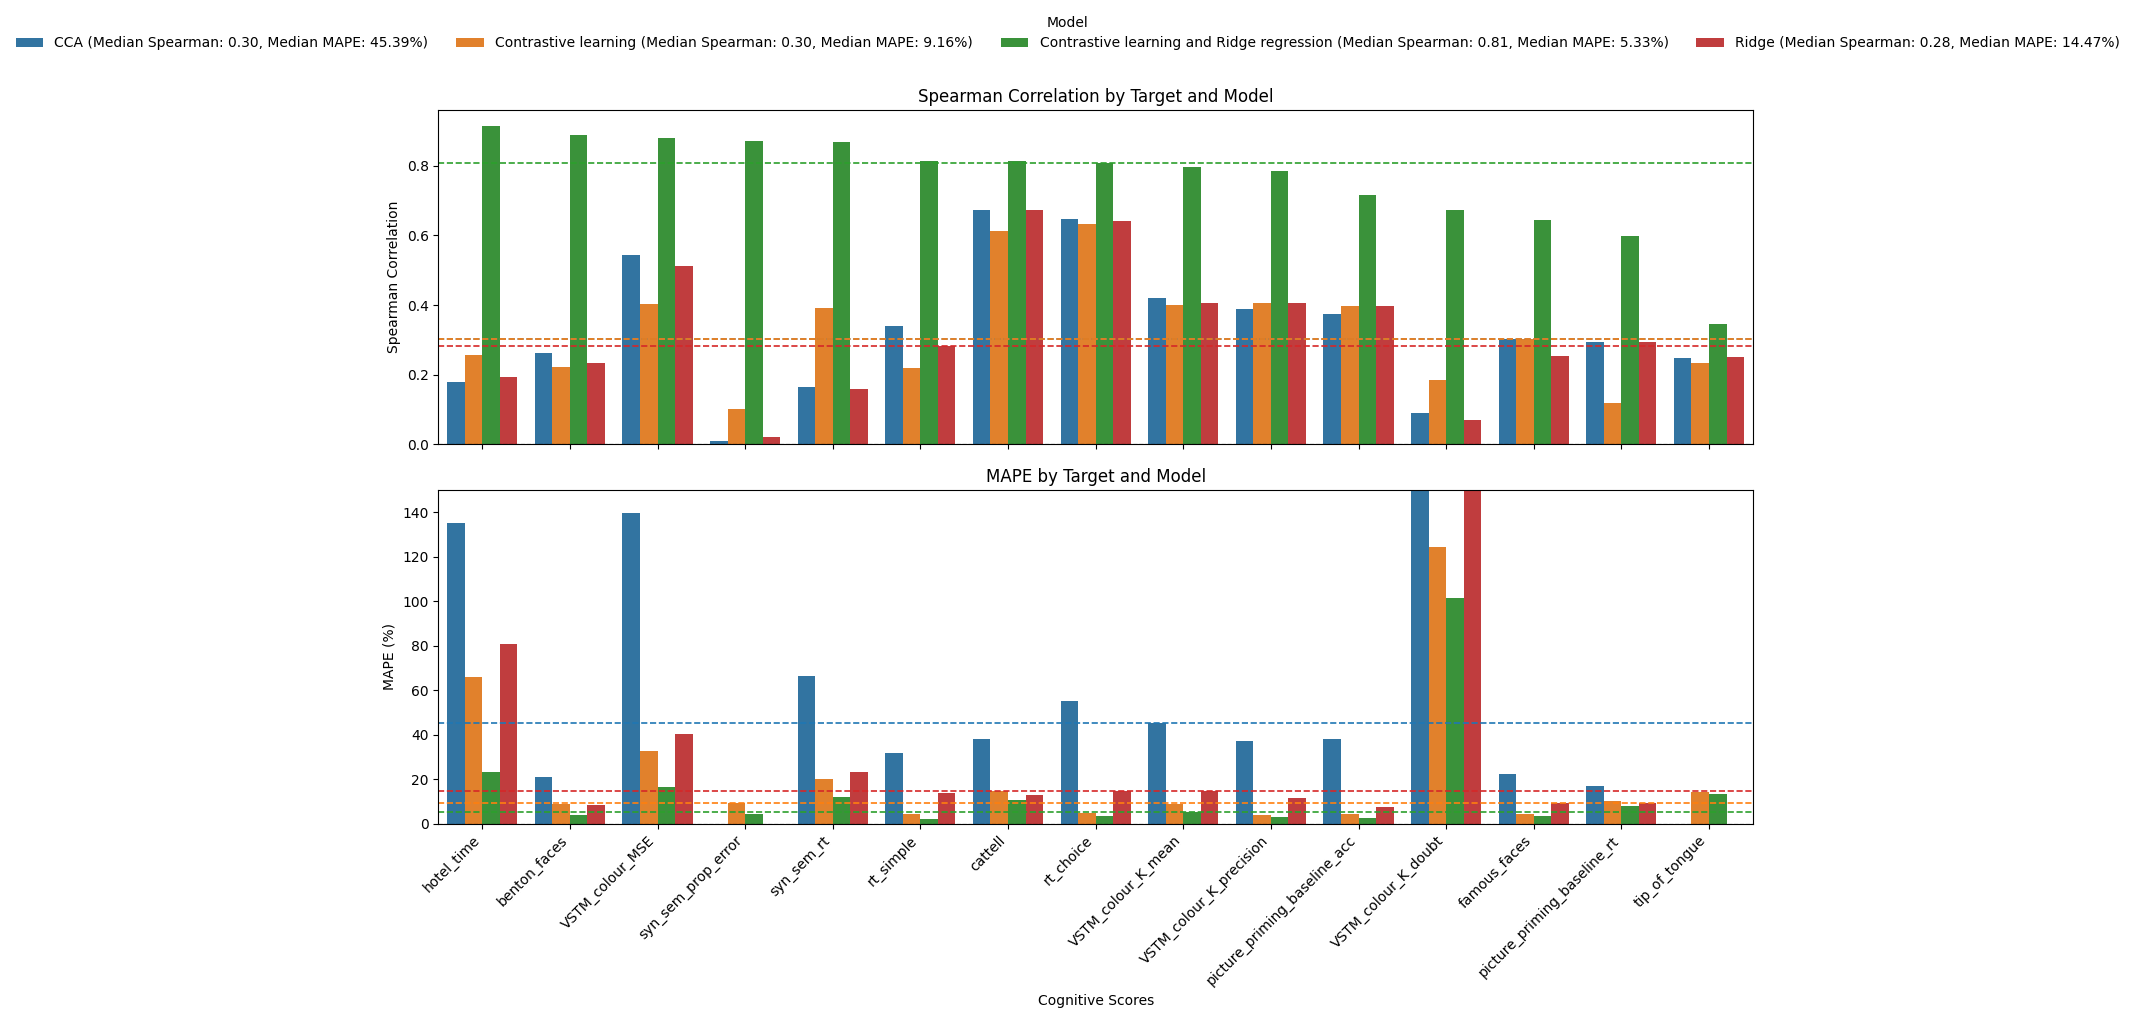

In [80]:
dataset_path = f"{root}/dataset_400parcels_2.nc"

targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

targets_to_plot = ["benton_faces", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_whole = ridge_pred(X_train, y_train, X_test, y_test)

cca_whole = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

plot_scores(ridge_whole, cca_whole, cr_pred_whole, targets_to_plot, model_and_ridge)
plot_median_scores(ridge_whole, cca_whole, cr_pred_whole, targets_to_plot, model_and_ridge)

## Residual plots

### Residuals vs true target : for most targets, there is a linear relationship between both, hence the idea for ridge regression on the residuals

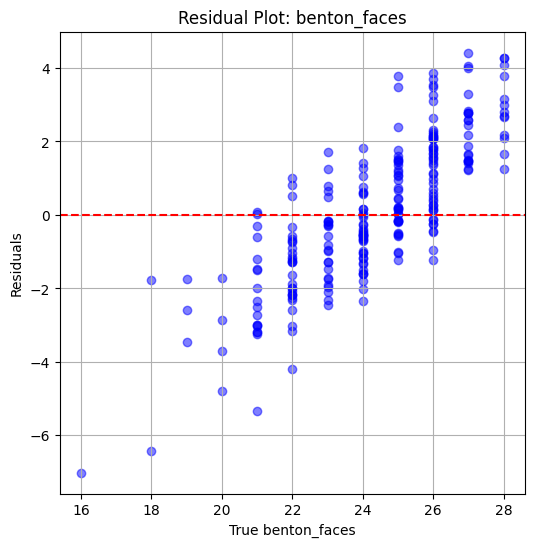

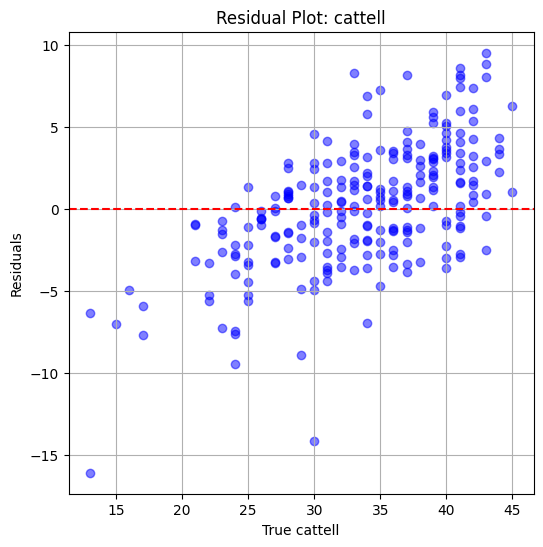

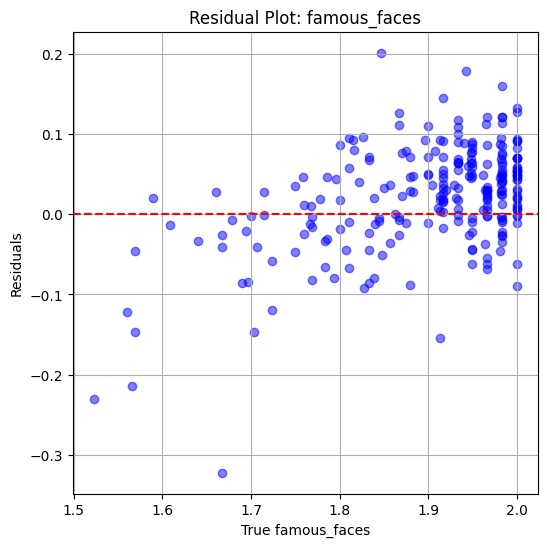

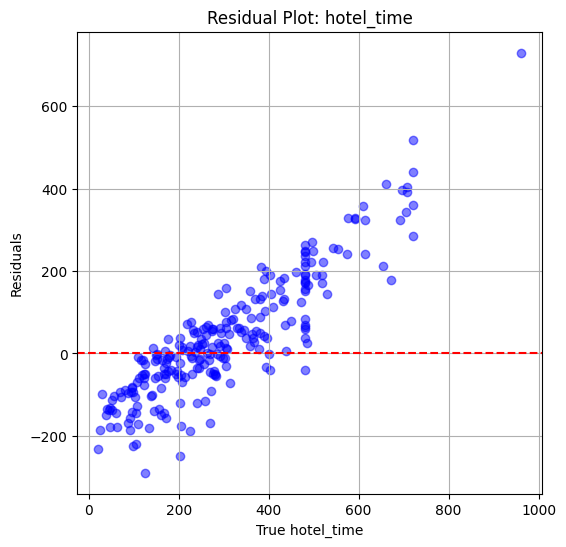

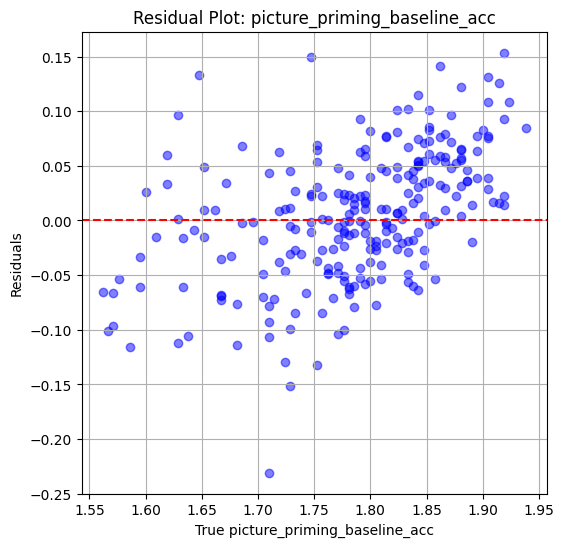

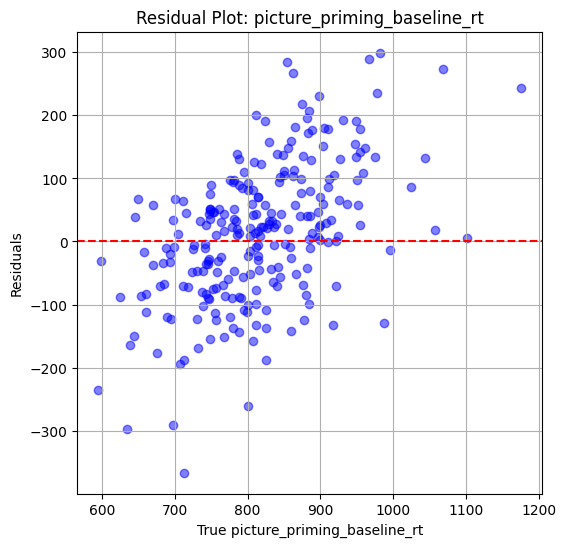

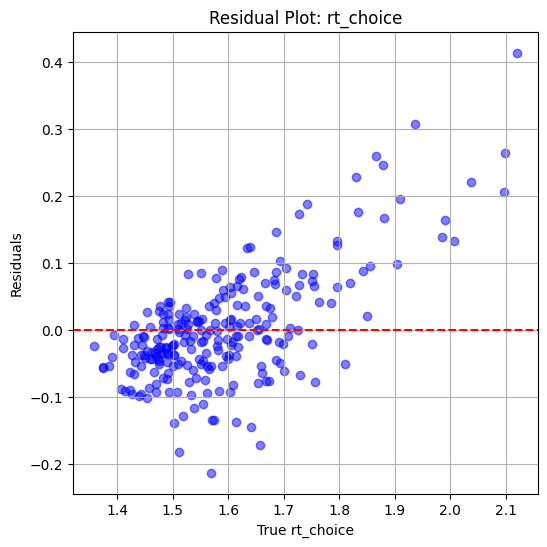

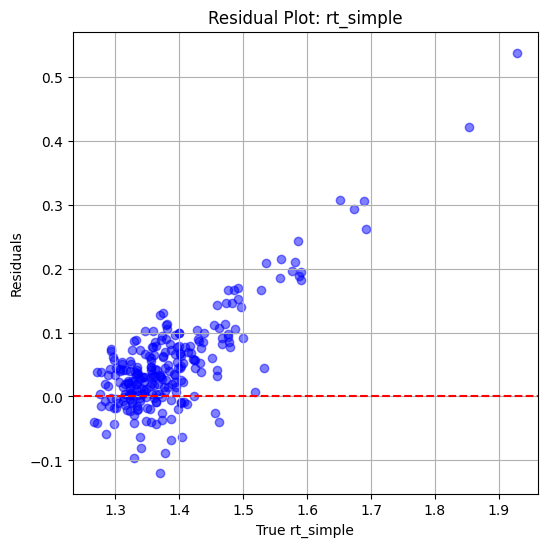

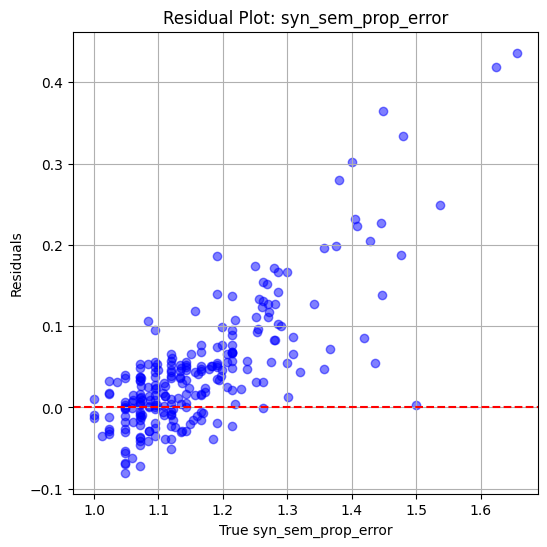

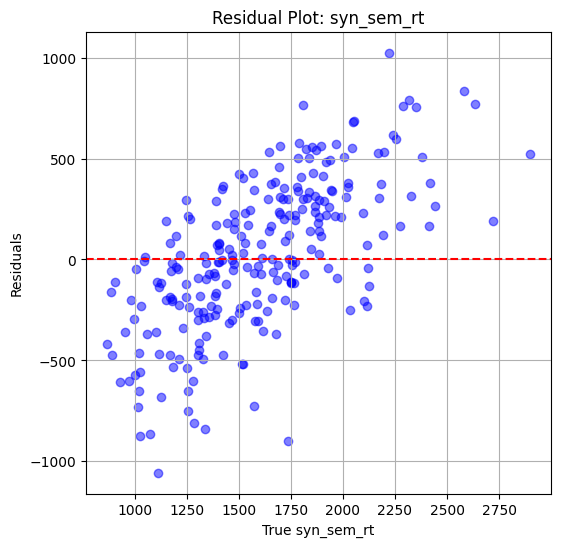

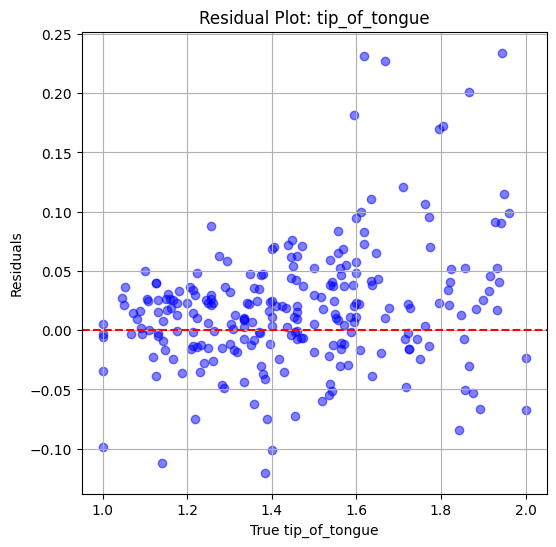

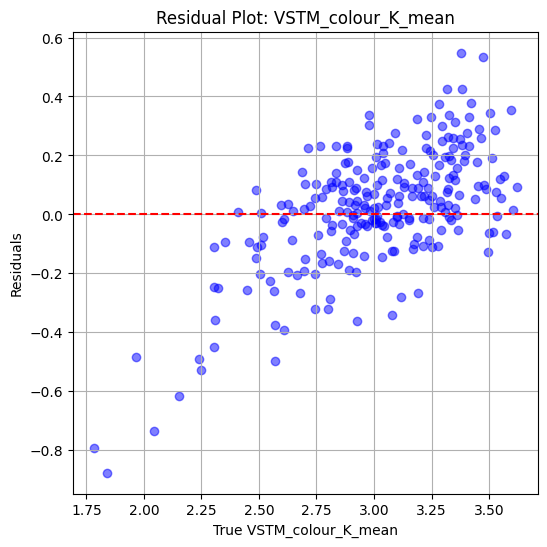

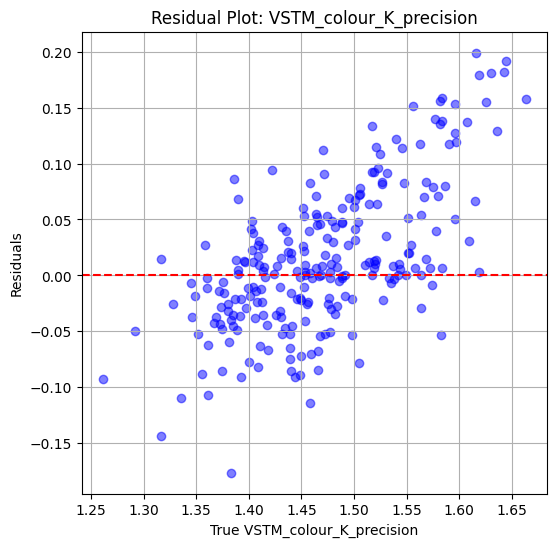

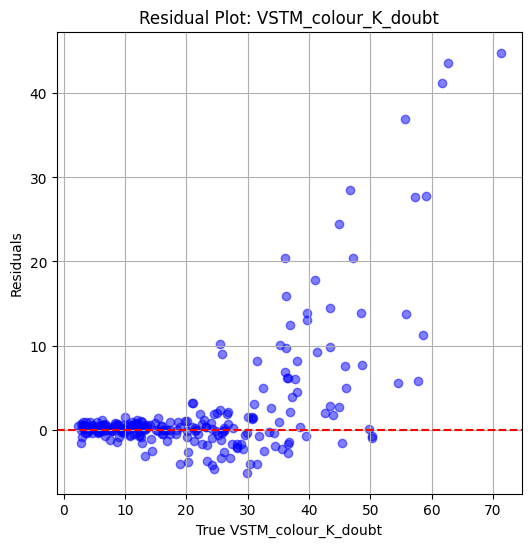

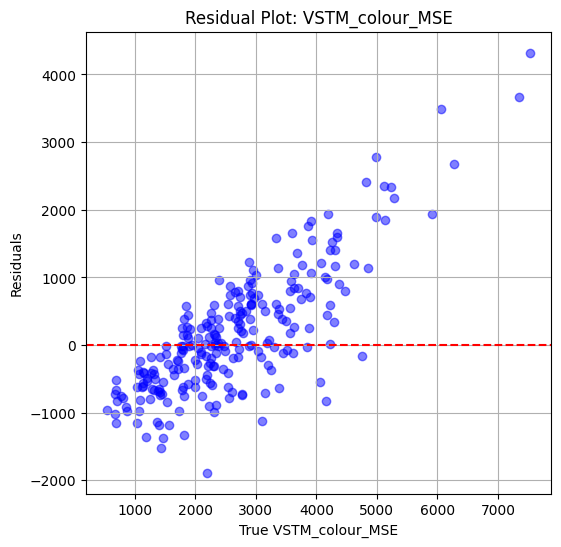

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
y_train_pred = X_train  # Assuming the model predictions are stored in the same format as X_train

# Calculate residuals
residuals_train = y_train - y_train_pred  # True values - predicted values

# Plot residuals for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train[:, i], residuals_train[:, i], alpha=0.5, color='b')
    plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0 (zero residuals)
    plt.title(f'Residual Plot: {target}')
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Residuals')
    plt.grid(True)
    plt.show()


### Residuals vs predicted targets : relationship is harder to define

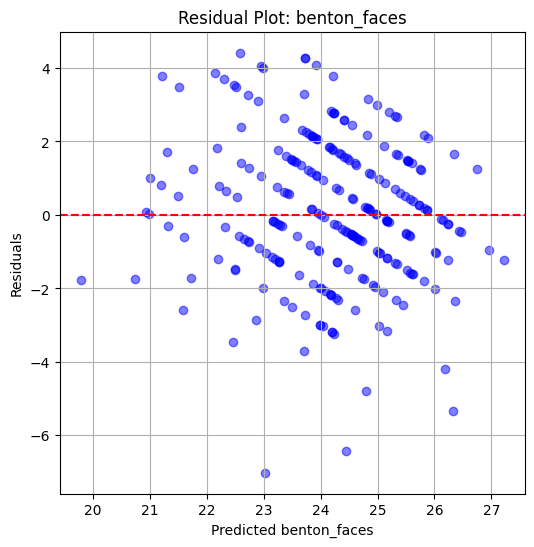

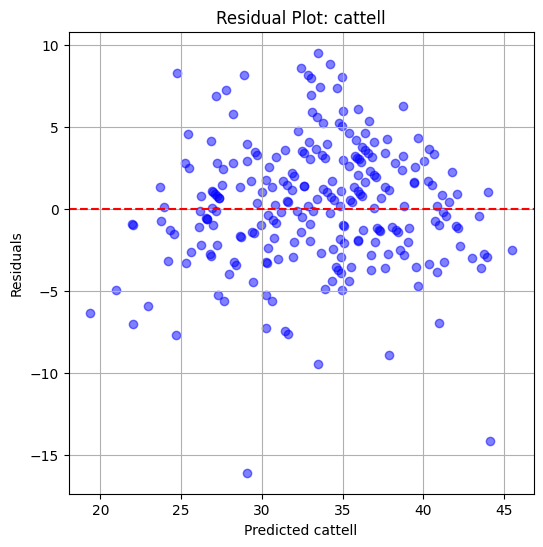

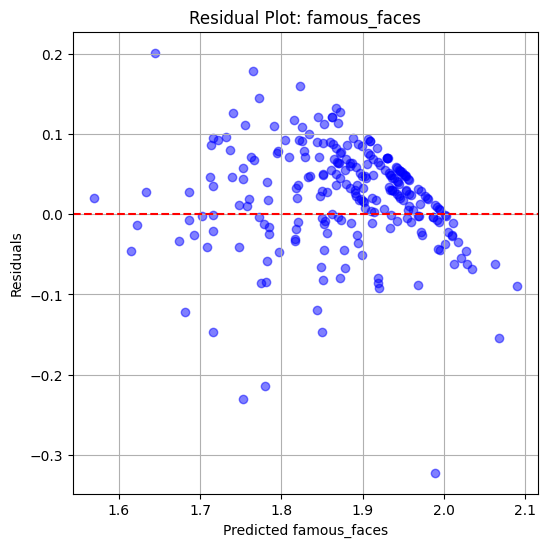

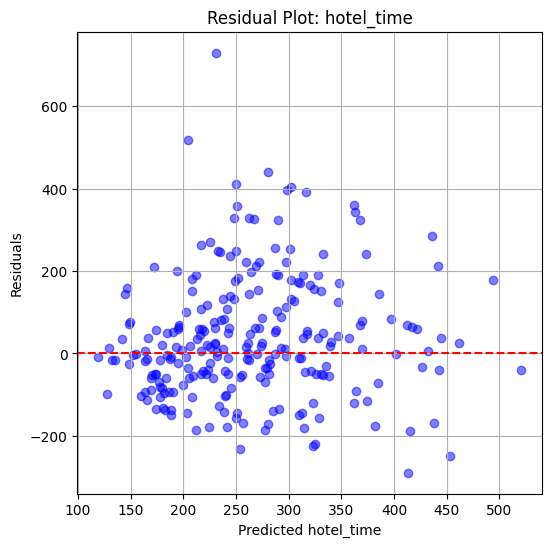

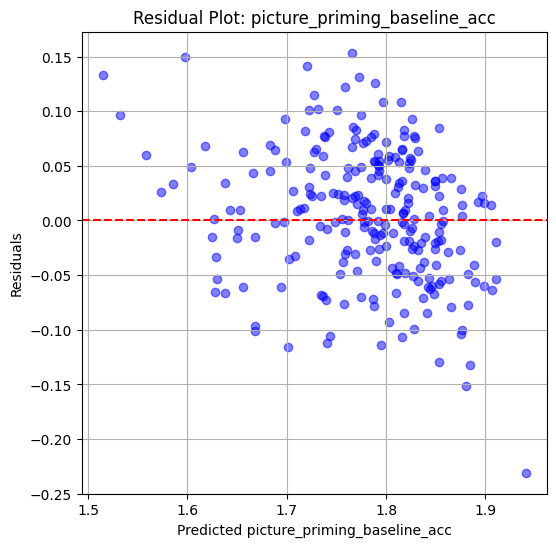

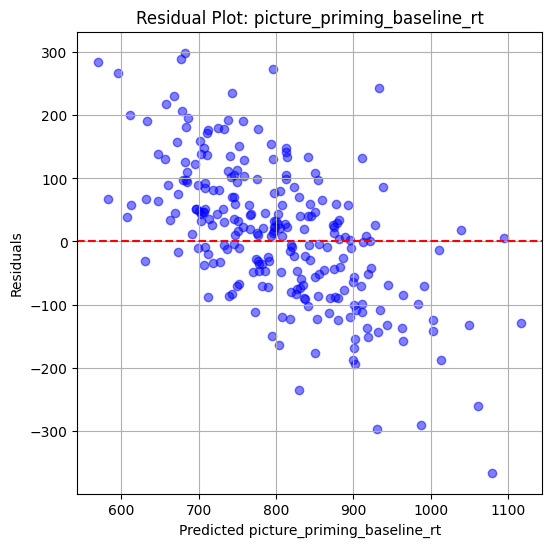

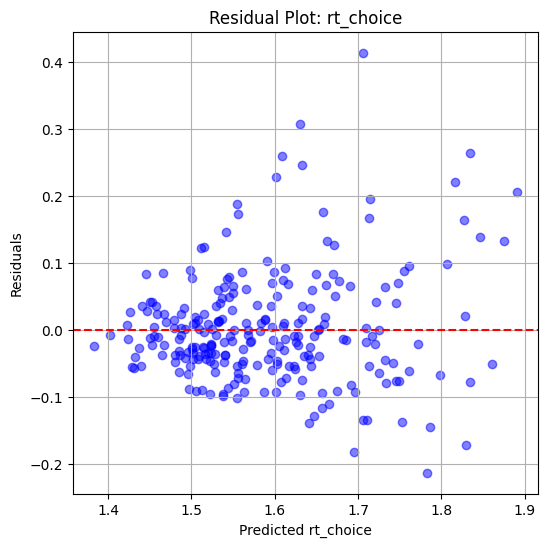

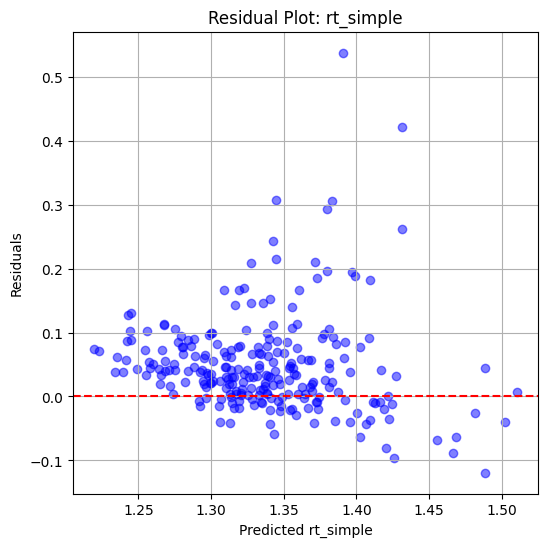

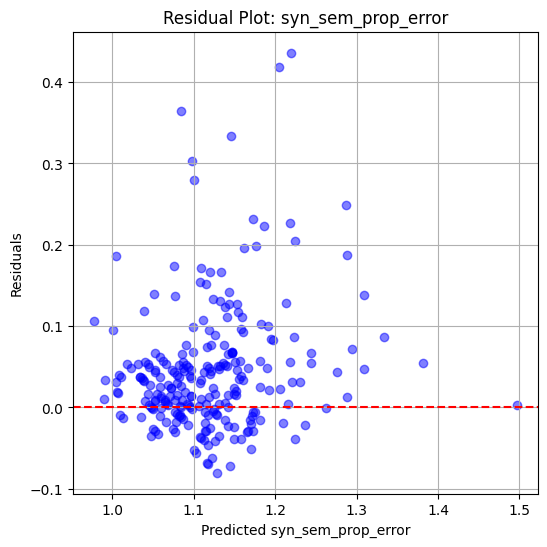

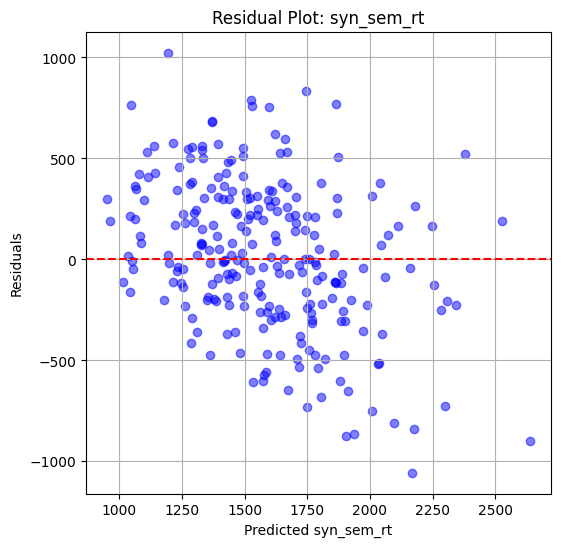

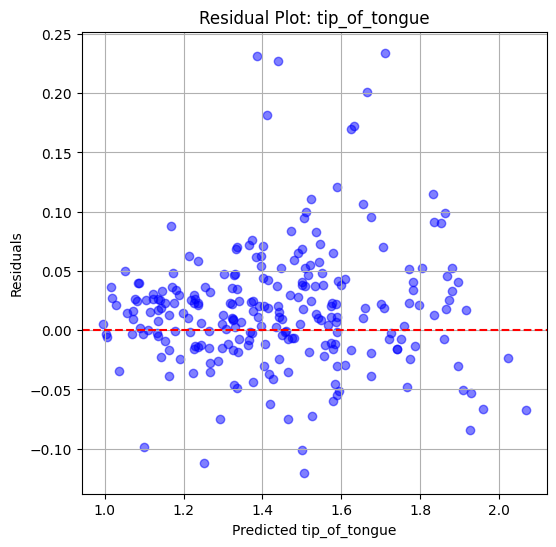

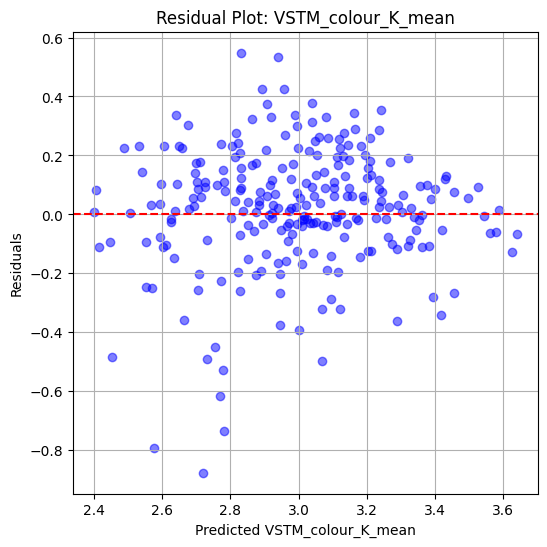

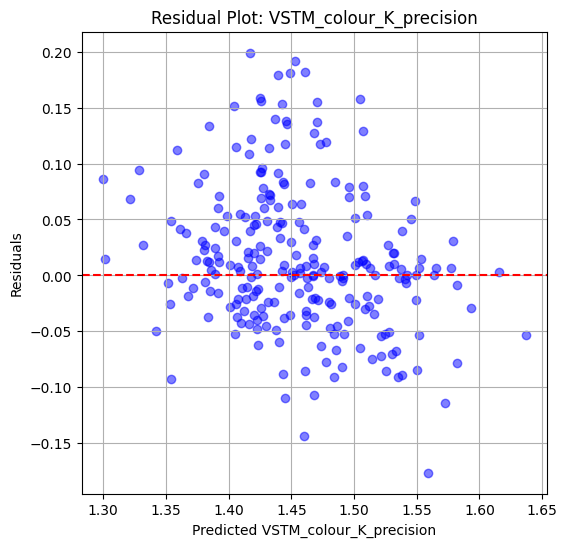

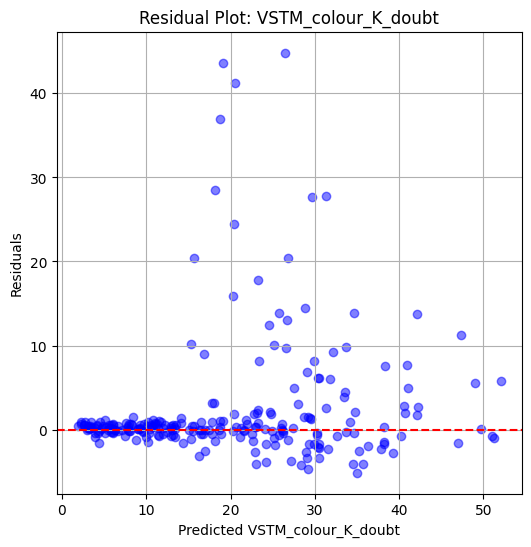

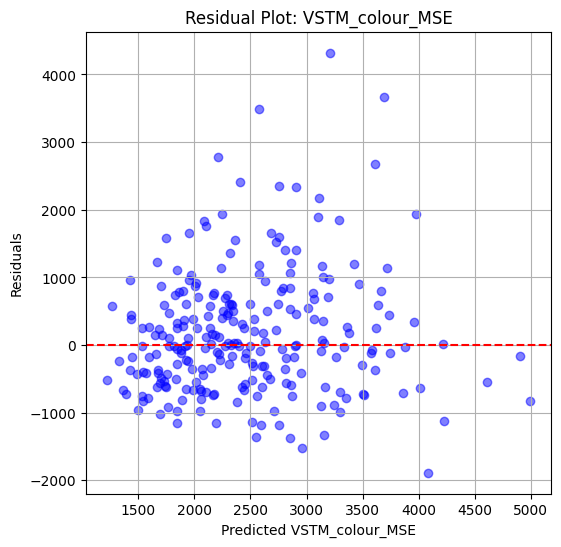

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values
y_train_pred = X_train  # Assuming the model predictions are stored in the same format as X_train

# Calculate residuals
residuals_train = y_train - y_train_pred  # True values - predicted values

# Plot residuals for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_pred[:, i], residuals_train[:, i], alpha=0.5, color='b')
    plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0 (zero residuals)
    plt.title(f'Residual Plot: {target}')
    plt.xlabel(f'Predicted {target}')
    plt.ylabel(f'Residuals')
    plt.grid(True)
    plt.show()


### True vs predicted 

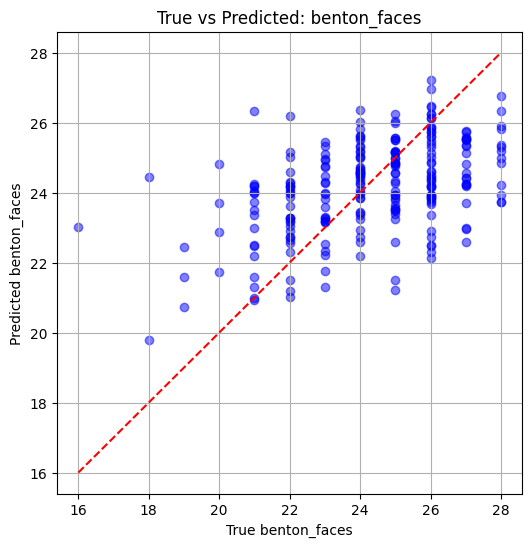

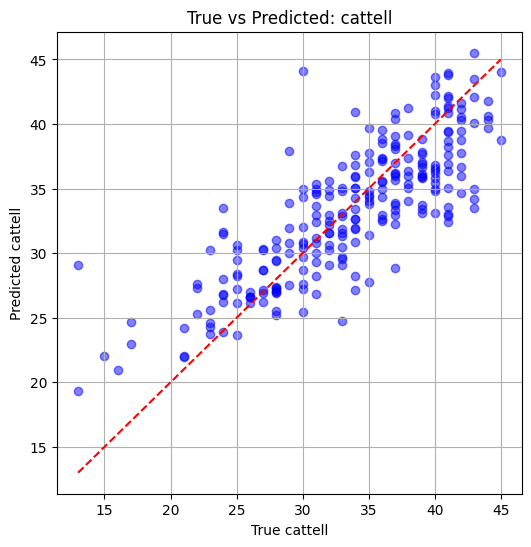

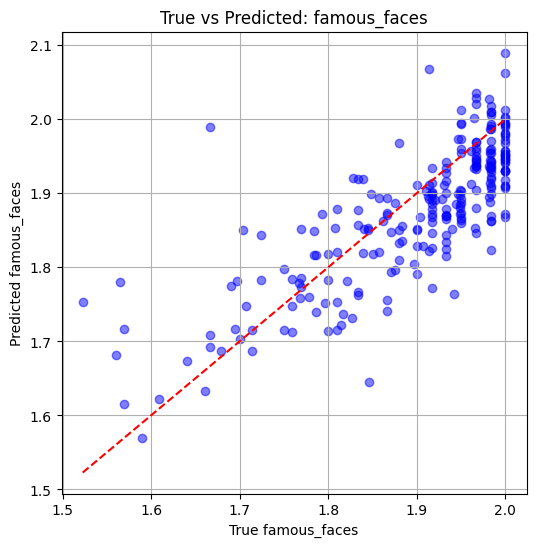

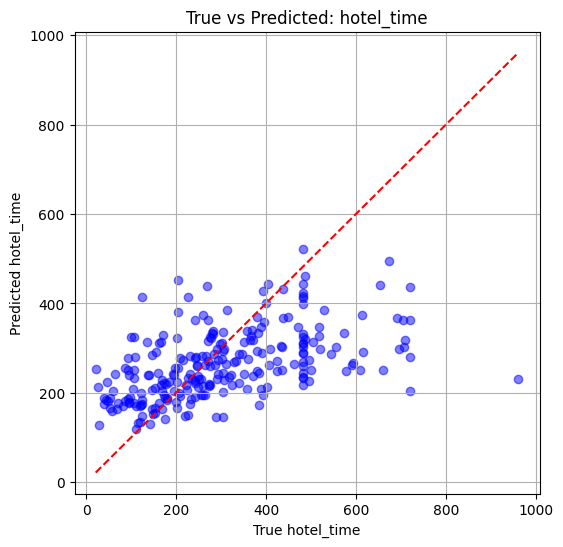

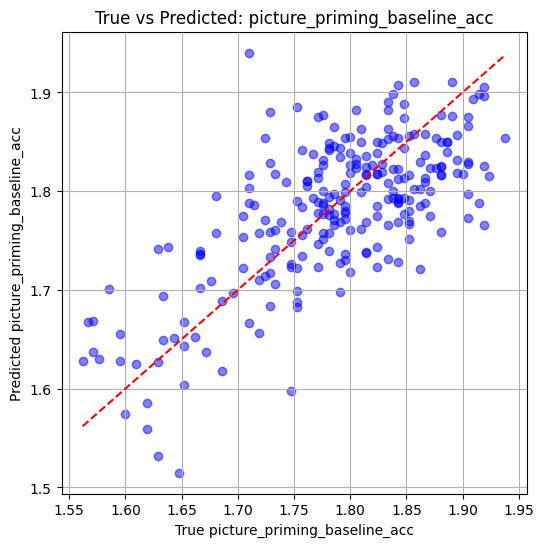

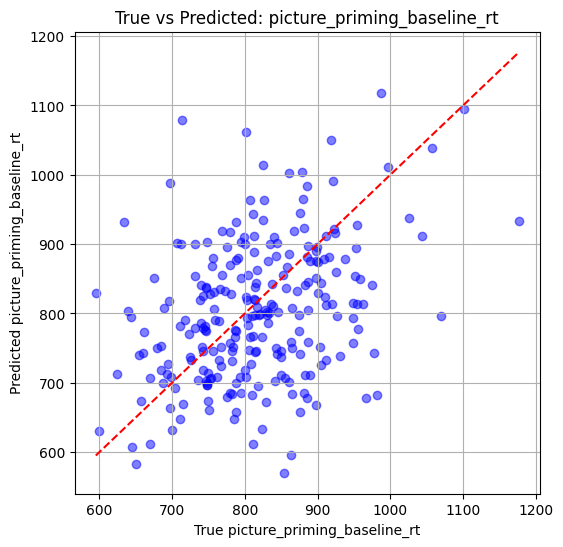

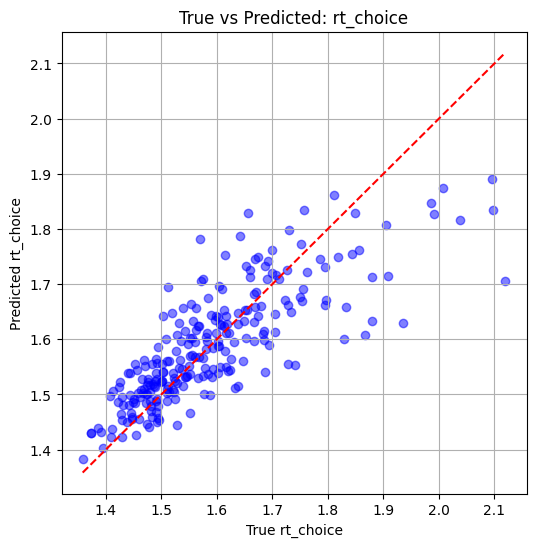

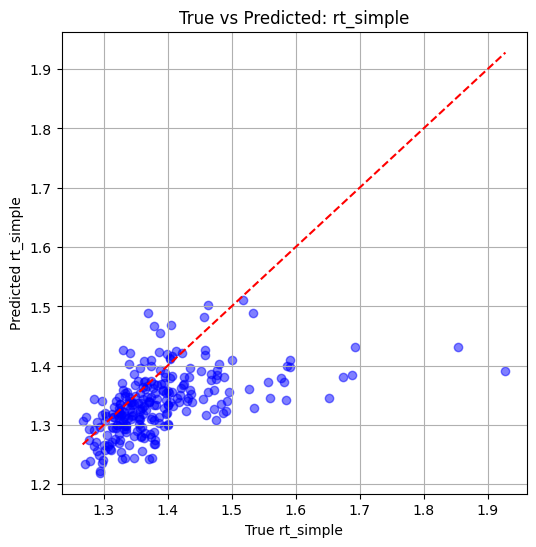

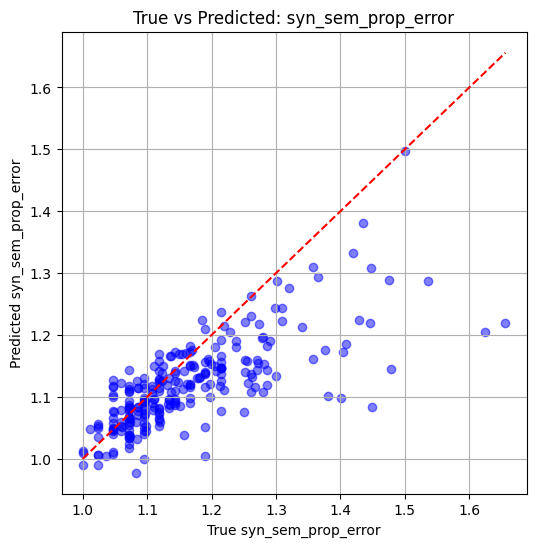

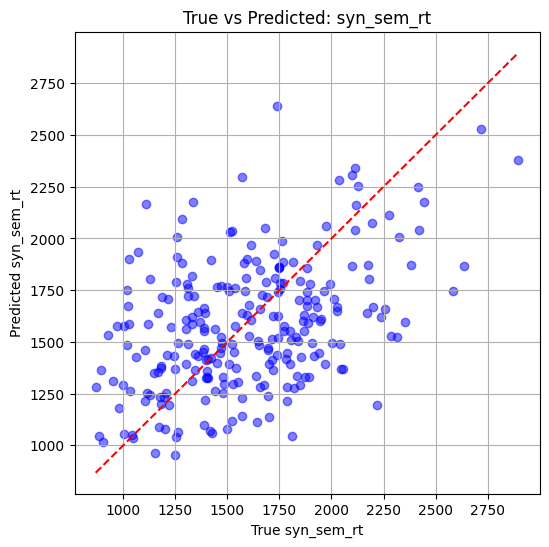

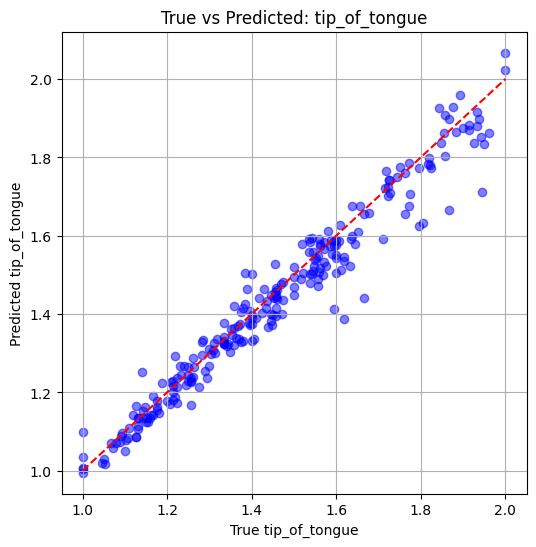

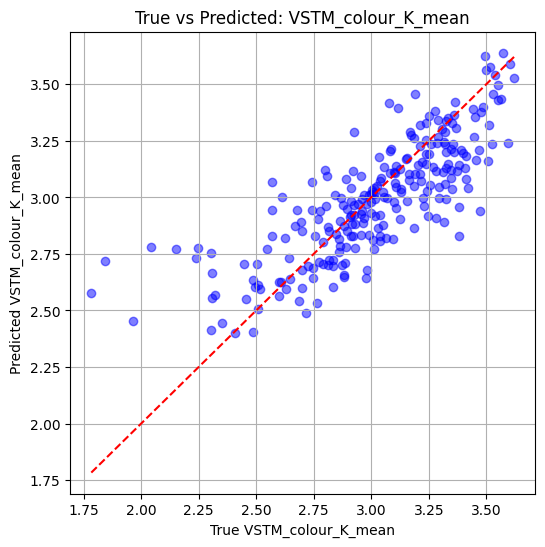

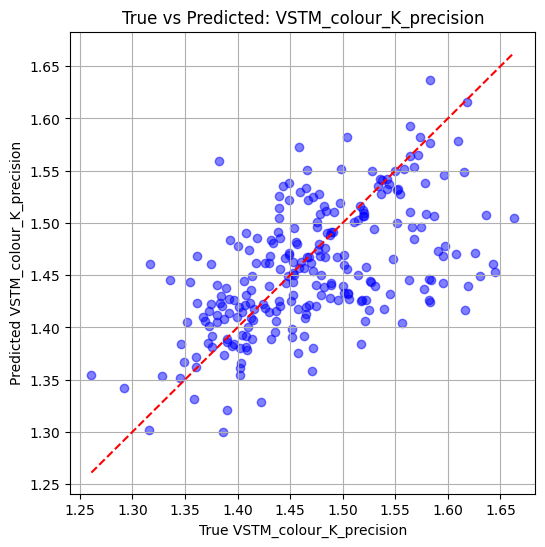

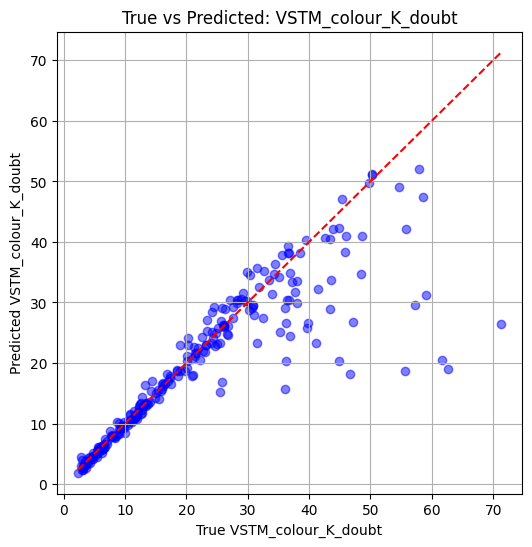

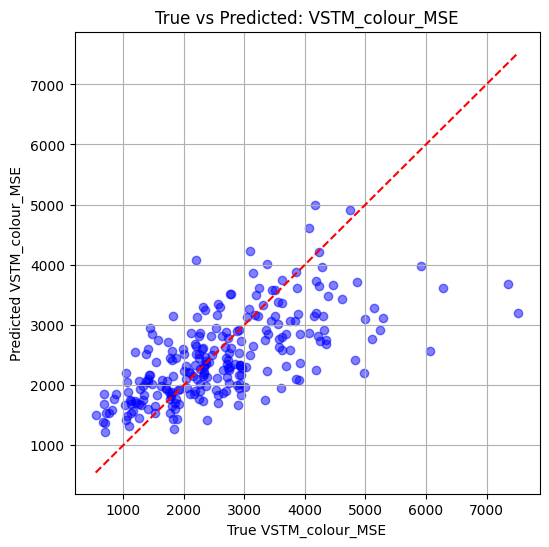

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]

# Ensure columns exist
assert set(target_cols).issubset(cr_pred_whole.columns), "Some target columns are missing."
assert set(pred_cols).issubset(cr_pred_whole.columns), "Some prediction columns are missing."

# Extract original and predicted values for train set
X_train = train_data[pred_cols].values
y_train = train_data[target_cols].values

# Plot true vs predicted values for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train[:, i], X_train[:, i], alpha=0.5, color='b')
    plt.plot([y_train[:, i].min(), y_train[:, i].max()], [y_train[:, i].min(), y_train[:, i].max()], color='red', linestyle='--')  # Line for perfect predictions
    plt.title(f'True vs Predicted: {target}')
    plt.xlabel(f'True {target}')
    plt.ylabel(f'Predicted {target}')
    plt.grid(True)
    plt.show()


## Comparisons with different sample sizes

In [ ]:
#Contrastive learning prediction results
cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")
cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

### 100 samples

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


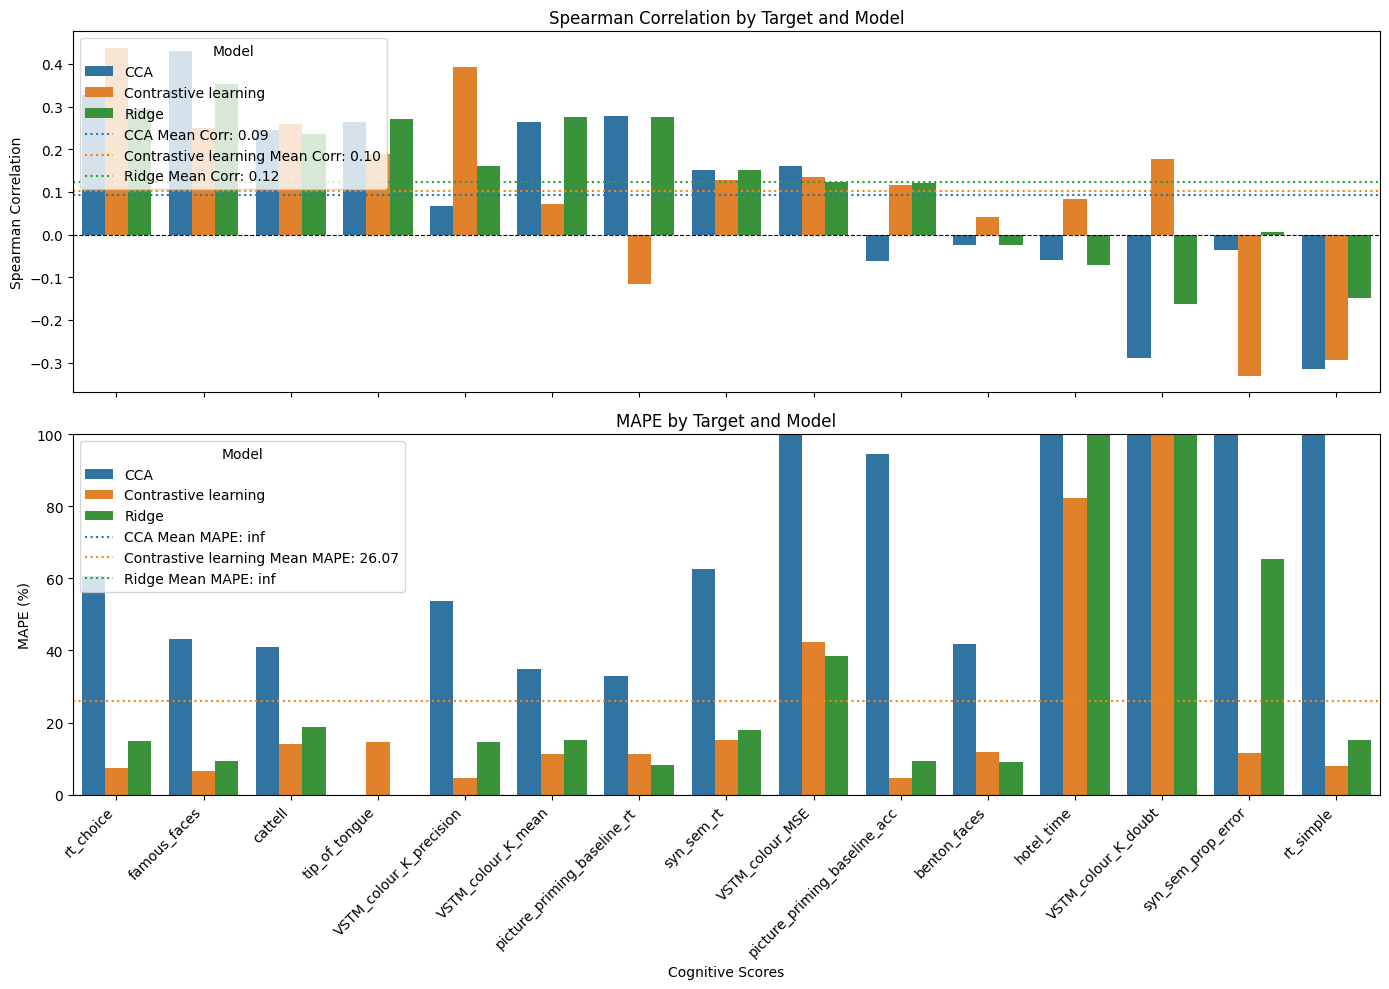

In [42]:
dataset_path = f"{root}/new_dataset_100_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_100 = ridge_pred(X_train, y_train, X_test, y_test)

cca_100 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")

plot_scores(ridge_100, cca_100, cr_pred_100, targets)


/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


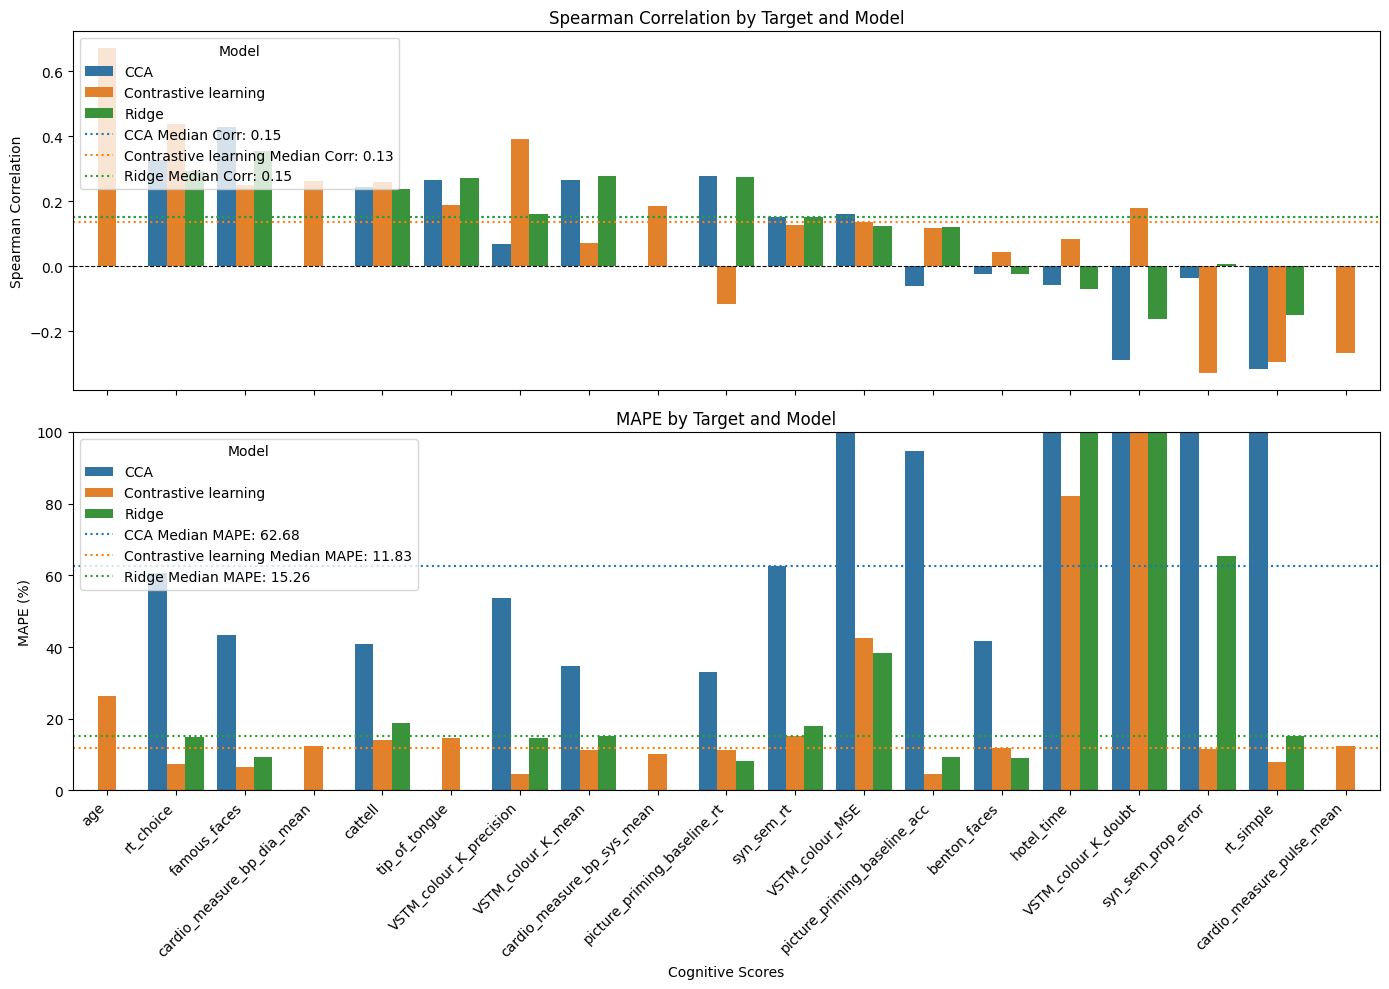

In [48]:
plot_median_scores(ridge_100, cca_100, cr_pred_100, targets)


### 200 samples

/tmp/ipykernel_2969458/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


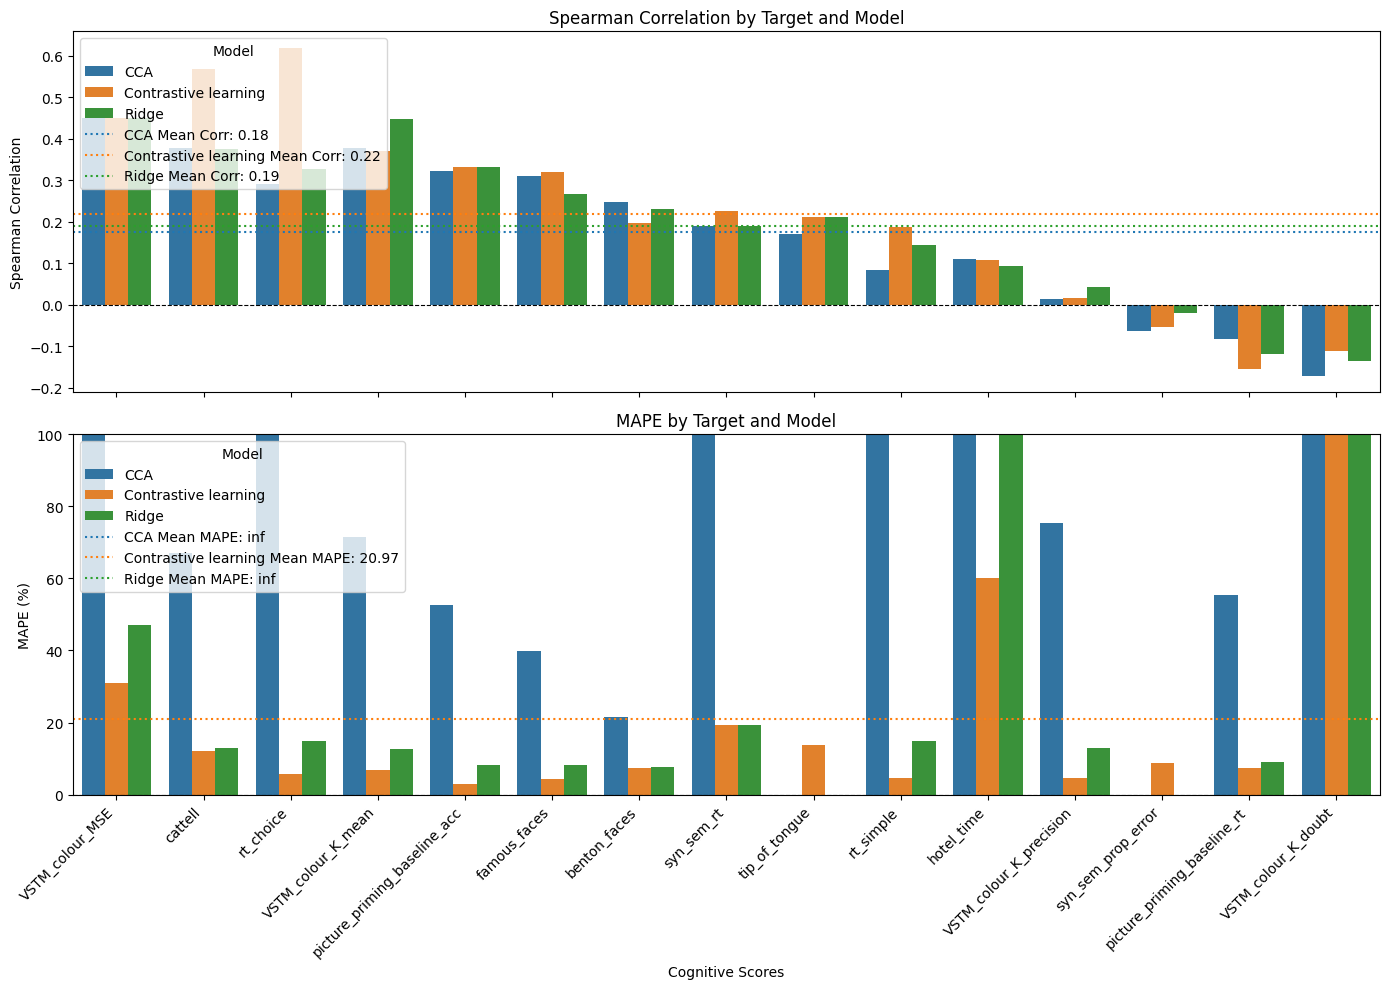

In [21]:
dataset_path = f"{root}/new_dataset_200_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_200 = ridge_pred(X_train, y_train, X_test, y_test)

cca_200 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")

plot_scores(ridge_200, cca_200, cr_pred_200, targets)

/tmp/ipykernel_2969458/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


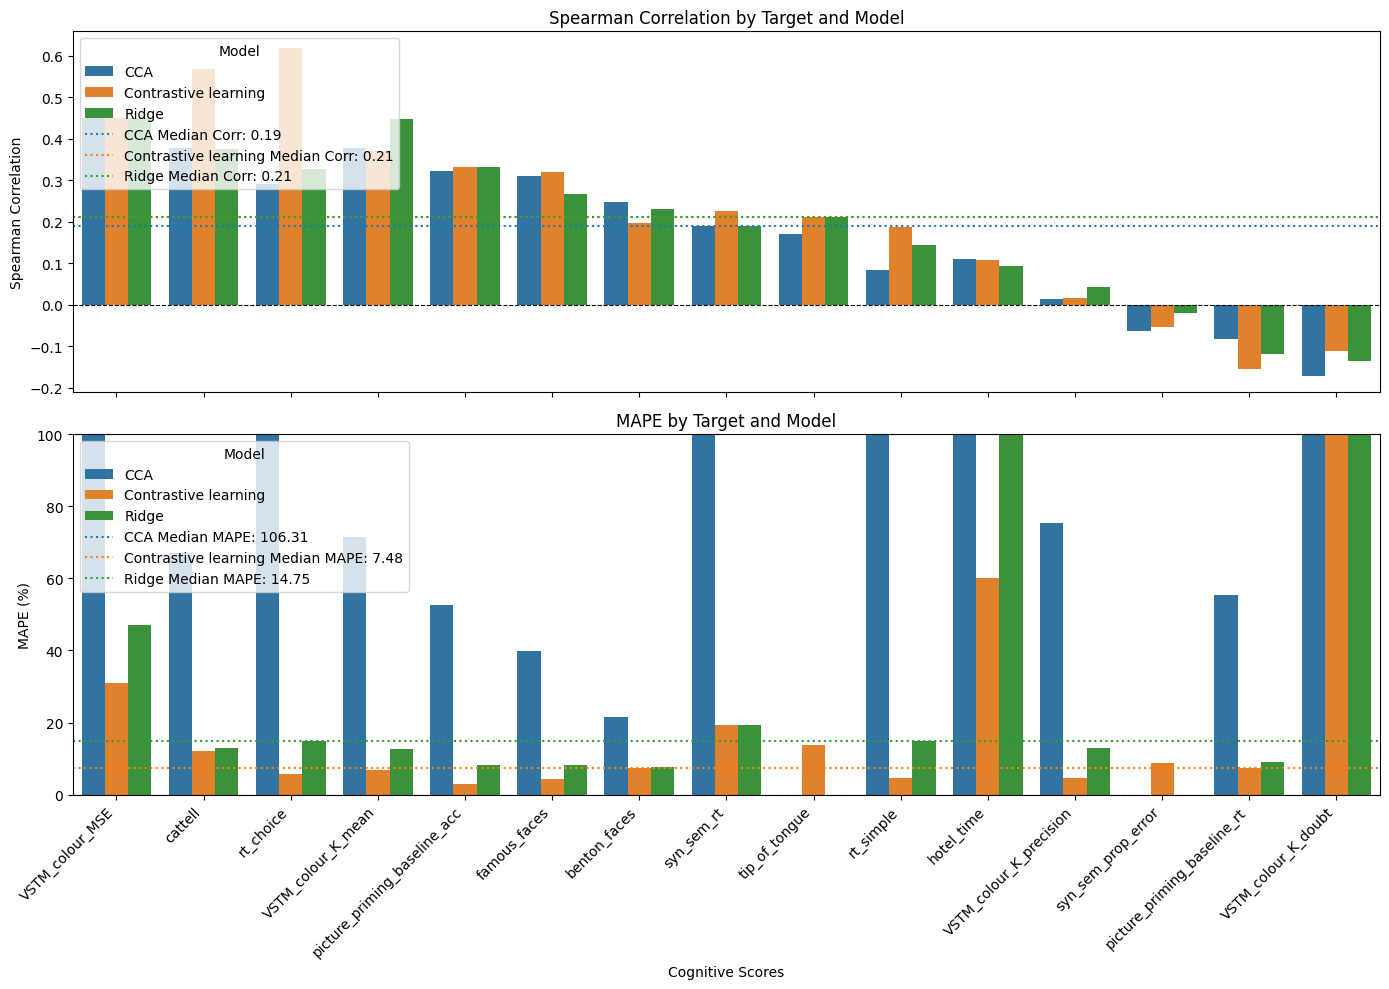

In [22]:
plot_median_scores(ridge_200, cca_200, cr_pred_200, targets)

## 10 runs and confidence intervals

In [107]:
# Load data
cr_pred_whole = pd.read_csv("results/final model with 10 runs + batch size : 32/pred_results.csv")
# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split data into train and test sets
train_data = cr_pred_whole[cr_pred_whole["dataset"] == "train"]
test_data = cr_pred_whole[cr_pred_whole["dataset"] == "test"]

# Extract target and prediction columns
target_cols = [col for col in targets if col in cr_pred_whole.columns]
pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in cr_pred_whole.columns]



# Extract original and predicted values for train and test sets
pred_target_train = train_data[pred_cols].values
true_target_train = train_data[target_cols].values
pred_target_test = test_data[pred_cols].values
true_target_test = test_data[target_cols].values

# Define residuals
residuals_train = true_target_train - pred_target_train  # Original targets - predicted values

# Initialize a list to store the results
y_train_pred = []
y_test_pred = []

# For each target, train a Ridge model separately
for i, target in enumerate(target_cols):
    # Define the Ridge regression model
    ridge_model = Ridge()

    # Cross-validate with weighted custom scorer
    param_grid = {
        "alpha": [0.1, 1.0, 10.0, 100.0, 50.0]  # Regularization strength
    }
    grid_search_ridge = GridSearchCV(
        ridge_model,
        param_grid=param_grid,
        cv=5,
        scoring= "r2"#make_scorer(custom_scorer_weighted, greater_is_better=False)
    )

    # Fit the model to residuals for the current target
    grid_search_ridge.fit(true_target_train, residuals_train[:, i].reshape(-1, 1))

    # Predict residuals for train and test sets
    residuals_train_pred = grid_search_ridge.predict(true_target_train)
    residuals_test_pred = grid_search_ridge.predict(true_target_test)

    # Correct predictions
    y_train_pred_target = pred_target_train[:, i] + residuals_train_pred.flatten()  # Add predicted residuals to initial predictions
    y_test_pred_target = pred_target_test[:, i] + residuals_test_pred.flatten()

    # Store results for each target
    y_train_pred.append(y_train_pred_target)
    y_test_pred.append(y_test_pred_target)

# Convert results to arrays
y_train_pred = np.array(y_train_pred).T
y_test_pred = np.array(y_test_pred).T

# Evaluate final performance
final_spearman_train = np.mean([
    spearmanr(true_target_train[:, i], y_train_pred[:, i])[0] for i in range(true_target_train.shape[1])
])
final_spearman_test = np.mean([
    spearmanr(true_target_test[:, i], y_test_pred[:, i])[0] for i in range(true_target_test.shape[1])
])
final_mape_train = mean_absolute_percentage_error(true_target_train, y_train_pred)
final_mape_test = mean_absolute_percentage_error(true_target_test, y_test_pred)

print(f"Train Spearman: {final_spearman_train}, Train MAPE: {final_mape_train}")
print(f"Test Spearman: {final_spearman_test}, Test MAPE: {final_mape_test}")



Train Spearman: 0.9390698687457902, Train MAPE: 0.050470164227876736
Test Spearman: 0.6365800501217252, Test MAPE: 0.1773404837582122


In [84]:
train_df = pd.DataFrame(true_target_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(true_target_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

model_and_ridge_10_runs =  pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

In [243]:
def ridge_pred_multiple_runs(X_train, y_train, X_test, y_test, targets, n_runs=10):
    all_results = []  # List to store results from all runs

    # First run: Save true targets and predictions as 'pred_run_0'
    print(f"Running Ridge Regression, Run 1/1")
    
    # Get predictions from ridge_pred function
    run_results_df = ridge_pred(X_train, y_train, X_test, y_test, targets)
    
    # Extract only test results
    test_results_df = run_results_df[run_results_df["dataset"] == "test"]
    
    # Save both true targets and predictions for the first run with 'pred_run_0'
    first_run_results = test_results_df[targets + [f"{target}_pred" for target in targets]]
    first_run_results.rename(columns={f"{target}_pred": f"{target}_pred_run_0" for target in targets}, inplace=True)
    all_results.append(first_run_results)

    # Subsequent runs: Only save predictions with the appropriate run number
    for run in range(1, n_runs):
        print(f"Running Ridge Regression, Run {run+1}/{n_runs}")
        seed = run
        
        # Get predictions from ridge_pred function
        run_results_df = ridge_pred(X_train, y_train, X_test, y_test, targets, random_seed = seed)
        
        # Extract only test results
        test_results_df = run_results_df[run_results_df["dataset"] == "test"]

        # Rename the predicted columns for this run
        renamed_pred_cols = {f"{target}_pred": f"{target}_pred_run_{run}" for target in targets}
        test_results_df.rename(columns=renamed_pred_cols, inplace=True)
        
        # Select only the predicted columns (no true targets)
        test_results_df = test_results_df[list(renamed_pred_cols.values())]

        all_results.append(test_results_df)

    # Concatenate results from all runs horizontally
    final_results_df = pd.concat(all_results, axis=1)

 

    return final_results_df


In [246]:

# Custom scorer for Spearman correlation
def spearman_corr(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]  # We only need the correlation coefficient

# Custom scorer for MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true+1e-5)) * 100  # Percentage error

# Convert custom scoring functions into sklearn's scorer
spearman_scorer = make_scorer(spearman_corr)
mape_scorer = make_scorer(mape, greater_is_better=False)  # MAPE should be minimized

def ridge_pred_with_cv(X_train, y_train, targets, n_runs=10):
    ridge_estimator = GridSearchCV(
        Ridge(),
        param_grid={"alpha": 10**(1/np.arange(-3, -1))},
        cv=5,
        scoring={'spearman': spearman_scorer, 'mape': mape_scorer},  # Use multiple scorers
        refit='spearman',  # Choose one metric to refit the model (for example, Spearman)
        return_train_score=True  # Access train and test scores
    )

    pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

    fitted_pipe = pipe_ridge.fit(X_train, y_train)

    # Get cross-validation scores for both metrics
    spearman_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_spearman']
    mape_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_mape']

    # Compute the mean and standard deviation of the scores
    mean_spearman = np.mean(spearman_scores)
    std_spearman = np.std(spearman_scores)
    mean_mape = np.mean(mape_scores)
    std_mape = np.std(mape_scores)

    # Calculate 95% confidence intervals for both metrics assuming normal distribution
    ci_lower_spearman = mean_spearman - 1.96 * (std_spearman / np.sqrt(len(spearman_scores)))
    ci_upper_spearman = mean_spearman + 1.96 * (std_spearman / np.sqrt(len(spearman_scores)))

    ci_lower_mape = mean_mape - 1.96 * (std_mape / np.sqrt(len(mape_scores)))
    ci_upper_mape = mean_mape + 1.96 * (std_mape / np.sqrt(len(mape_scores)))

    print(f"Mean Spearman Correlation: {mean_spearman}")
    print(f"95% Confidence Interval for Spearman: ({ci_lower_spearman}, {ci_upper_spearman})")
    print(f"Mean MAPE: {mean_mape}")
    print(f"95% Confidence Interval for MAPE: ({ci_lower_mape}, {ci_upper_mape})")

    return {
        'mean_spearman': mean_spearman,
        'ci_lower_spearman': ci_lower_spearman,
        'ci_upper_spearman': ci_upper_spearman,
        'mean_mape': mean_mape,
        'ci_lower_mape': ci_lower_mape,
        'ci_upper_mape': ci_upper_mape
    }

# Example usage
results = ridge_pred_with_cv(X_train, y_train, targets)


/tmp/ipykernel_2969458/1717132880.py:7: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true+1e-5)) * 100  # Percentage error


ValueError: scoring must return a number, got [[ 1.         -0.5224152   0.13019702 ... -0.41720941 -0.23056309
   0.57444169]
 [-0.5224152   1.          0.01106661 ...  0.01737251 -0.05005551
  -0.11542151]
 [ 0.13019702  0.01106661  1.         ...  0.024663   -0.04871325
  -0.02022059]
 ...
 [-0.41720941  0.01737251  0.024663   ...  1.          0.05071429
  -0.70020408]
 [-0.23056309 -0.05005551 -0.04871325 ...  0.05071429  1.
  -0.10091837]
 [ 0.57444169 -0.11542151 -0.02022059 ... -0.70020408 -0.10091837
   1.        ]] (<class 'numpy.ndarray'>) instead. (scorer=spearman)

In [238]:
ridge_whole

age  benton_faces  cardio_measure_pulse_mean  \
245  57.0          24.0                       78.0   
246  76.0          21.0                       68.5   
247  29.0          27.0                       53.5   
248  33.0          21.0                       48.0   
249  76.0          20.0                       56.5   
..    ...           ...                        ...   
346  32.0          23.0                       70.0   
347  45.0          24.0                       89.5   
348  29.0          21.0                       73.5   
349  36.0          25.0                       54.5   
350  66.0          22.0                       59.0   

     cardio_measure_bp_sys_mean  cardio_measure_bp_dia_mean  cattell  \
245                       157.0                        99.5     30.0   
246                       138.0                        76.0     16.0   
247                       114.5                        63.0     40.0   
248                       111.0                        66.5     33.0   
249                       126.5                        75.0     35.0   
..                          ...                         ...      ...   
346                        95.5                        66.5     35.0   
347                       132.5                        82.5     35.0   
348                       110.5                        81.0     37.0   
349                       133.5                        70.0     38.0   
350                       132.0                        75.0     32.0   

     famous_faces  hotel_time  picture_priming_baseline_acc  \
245      0.800000  705.840027                      0.776191   
246      0.758621  392.029999                      0.619048   
247      0.866667   92.940002                      0.809524   
248      0.866667  286.809998                      0.771429   
249      0.807692  331.940002                      0.795238   
..            ...         ...                           ...   
346      0.983333  240.000000                      0.795238   
347      0.982759  106.220001                      0.866667   
348      1.000000  223.779999                      0.852381   
349      0.950000  254.720001                      0.904762   
350      0.983333   91.620003                      0.852381   

     picture_priming_baseline_rt  rt_choice  rt_simple  syn_sem_prop_error  \
245                        877.0   0.538704   0.358079            0.205952   
246                        910.0   0.990356   0.433023            0.419173   
247                        747.0   0.418816   0.312197            0.142857   
248                        678.0   0.478652   0.297638            0.095238   
249                        888.0   0.616412   0.491750            0.086134   
..                           ...        ...        ...                 ...   
346                        854.0   0.523605   0.346600            0.097024   
347                        787.0   0.638594   0.355559            0.096429   
348                        725.0   0.502869   0.423677            0.375595   
349                        910.0   0.492201   0.400458            0.071429   
350                        660.0   0.829705   0.459486            0.085119   

      syn_sem_rt  tip_of_tongue  VSTM_colour_K_mean  VSTM_colour_K_precision  \
245  2033.300049       0.607143            1.239373                 0.518768   
246  2275.399902       0.815790            1.835492                 0.348987   
247  1292.300049       0.454545            2.460438                 0.525608   
248  1507.199951       0.580645            2.277258                 0.586526   
249  2113.800049       0.608696            2.123317                 0.501078   
..           ...            ...                 ...                      ...   
346  1480.800049       0.294118            2.326838                 0.520579   
347  1655.599976       0.357143            2.410864                 0.426508   
348  1799.000000       0.541667            2.185212                 0.510715  

In [274]:
targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

targets_to_plot = ["benton_faces", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]


def spearman_corr(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return spearmanr(y_true, y_pred)[0]  # We only need the correlation coefficient

# Convert custom scoring functions into sklearn's scorer
spearman_scorer = make_scorer(spearman_corr)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)  # MAPE should be minimized

def ridge_pred(X_train, y_train, X_test, y_test, targets, random_seed=42):
    all_results = []
      # Ensure y_train and y_test are DataFrames
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train, columns=targets)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test, columns=targets)
    
    # Loop through each target separately
    for target in targets:
        print(f"Processing target: {target}")
        
        # Extract the target column from the train and test datasets
        y_train_target = y_train[target].values.reshape(-1, 1)
        y_test_target = y_test[target].values.reshape(-1, 1)

        # Set up the Ridge model with cross-validation and custom scoring
        ridge_estimator = GridSearchCV(
            Ridge(),
            param_grid={"alpha": [0.1, 1.0, 10.0, 100.0]},
            cv=10,
            scoring={'spearman': spearman_scorer, 'mape': mape_scorer},
            refit='spearman',  # Choose one metric to refit the model (for example, Spearman)
            return_train_score=True  # Access train and test scores
        )

        # Pipeline with scaling and Ridge model
        pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

        # Fit the model
        fitted_pipe = pipe_ridge.fit(X_train, y_train_target)

        # Get predictions for train and test data
        y_train_pred = fitted_pipe.predict(X_train)
        y_test_pred = fitted_pipe.predict(X_test)

        # Prepare DataFrame for the predictions
        train_df = pd.DataFrame(y_train_target, columns=[target])
        train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred"])
        train_results_df = pd.concat([train_df, train_pred_df], axis=1)
        train_results_df["dataset"] = "train"

        test_df = pd.DataFrame(y_test_target, columns=[target])
        test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred"])
        test_results_df = pd.concat([test_df, test_pred_df], axis=1)
        test_results_df["dataset"] = "test"

        # Combine train and test results into a single DataFrame
        all_results.append(pd.concat([train_results_df, test_results_df]).reset_index(drop=True))

        # Initialize results dictionary for the current target
        target_results = {}

        # Extract cross-validation scores for both metrics (Spearman and MAPE) for the current target
        spearman_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_spearman']
        mape_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_mape']

        # Compute the mean and standard deviation of the scores
        mean_spearman = np.mean(spearman_scores)
        std_spearman = np.std(spearman_scores)
        mean_mape = np.mean(mape_scores)
        std_mape = np.std(mape_scores)

        # Calculate 95% confidence intervals for both metrics assuming normal distribution
        ci_lower_spearman = mean_spearman - 1.96 * (std_spearman / np.sqrt(len(spearman_scores)))
        ci_upper_spearman = mean_spearman + 1.96 * (std_spearman / np.sqrt(len(spearman_scores)))

        ci_lower_mape = mean_mape - 1.96 * (std_mape / np.sqrt(len(mape_scores)))
        ci_upper_mape = mean_mape + 1.96 * (std_mape / np.sqrt(len(mape_scores)))

        # Store the results per target
        target_results[target] = {
            'mean_spearman': mean_spearman,
            'ci_lower_spearman': ci_lower_spearman,
            'ci_upper_spearman': ci_upper_spearman,
            'mean_mape': mean_mape,
            'ci_lower_mape': ci_lower_mape,
            'ci_upper_mape': ci_upper_mape
        }

        # Print out the results for the current target
        print(f"Results for target '{target}':")
        print(f"Mean Spearman Correlation: {mean_spearman}")
        print(f"95% Confidence Interval for Spearman: ({ci_lower_spearman}, {ci_upper_spearman})")
        print(f"Mean MAPE: {mean_mape}")
        print(f"95% Confidence Interval for MAPE: ({ci_lower_mape}, {ci_upper_mape})")
        print()

    # Combine all the results for each target
    final_results_df = pd.concat(all_results).reset_index(drop=True)

    return final_results_df, target_results


In [ ]:
targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

targets_to_plot = ["benton_faces", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]


def spearman_corr(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return spearmanr(y_true, y_pred)[0]  # We only need the correlation coefficient

# Convert custom scoring functions into sklearn's scorer
spearman_scorer = make_scorer(spearman_corr)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)  # MAPE should be minimized

def ridge_pred(X_train, y_train, X_test, y_test, targets, random_seed=42):
    all_results = []
      # Ensure y_train and y_test are DataFrames
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train, columns=targets)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test, columns=targets)
    
    # Loop through each target separately
    for target in targets:
        print(f"Processing target: {target}")
        
        # Extract the target column from the train and test datasets
        y_train_target = y_train[target].values.reshape(-1, 1)
        y_test_target = y_test[target].values.reshape(-1, 1)

        # Set up the Ridge model with cross-validation and custom scoring
        ridge_estimator = GridSearchCV(
            Ridge(),
            param_grid={"alpha": [0.1, 1.0, 10.0, 100.0]},
            cv=10,
            scoring={'spearman': spearman_scorer, 'mape': mape_scorer},
            refit='spearman',  # Choose one metric to refit the model (for example, Spearman)
            return_train_score=True  # Access train and test scores
        )

        # Pipeline with scaling and Ridge model
        pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

        # Fit the model
        fitted_pipe = pipe_ridge.fit(X_train, y_train_target)

        # Get predictions for train and test data
        y_train_pred = fitted_pipe.predict(X_train)
        y_test_pred = fitted_pipe.predict(X_test)

        # Prepare DataFrame for the predictions
        train_df = pd.DataFrame(y_train_target, columns=[target])
        train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred"])
        train_results_df = pd.concat([train_df, train_pred_df], axis=1)
        train_results_df["dataset"] = "train"

        test_df = pd.DataFrame(y_test_target, columns=[target])
        test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred"])
        test_results_df = pd.concat([test_df, test_pred_df], axis=1)
        test_results_df["dataset"] = "test"

        # Combine train and test results into a single DataFrame
        all_results.append(pd.concat([train_results_df, test_results_df]).reset_index(drop=True))

        # Initialize results dictionary for the current target
        target_results = {}

        # Extract cross-validation scores for both metrics (Spearman and MAPE) for the current target
        spearman_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_spearman']
        mape_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_mape']

        # Compute the mean and standard deviation of the scores
        mean_spearman = np.mean(spearman_scores)
        std_spearman = np.std(spearman_scores)
        mean_mape = np.mean(mape_scores)
        std_mape = np.std(mape_scores)

        # Calculate 95% confidence intervals for both metrics assuming normal distribution
        ci_lower_spearman = mean_spearman - 1.96 * (std_spearman / np.sqrt(len(spearman_scores)))
        ci_upper_spearman = mean_spearman + 1.96 * (std_spearman / np.sqrt(len(spearman_scores)))

        ci_lower_mape = mean_mape - 1.96 * (std_mape / np.sqrt(len(mape_scores)))
        ci_upper_mape = mean_mape + 1.96 * (std_mape / np.sqrt(len(mape_scores)))

        # Store the results per target
        target_results[target] = {
            'mean_spearman': mean_spearman,
            'ci_lower_spearman': ci_lower_spearman,
            'ci_upper_spearman': ci_upper_spearman,
            'mean_mape': mean_mape,
            'ci_lower_mape': ci_lower_mape,
            'ci_upper_mape': ci_upper_mape
        }

        # Print out the results for the current target
        print(f"Results for target '{target}':")
        print(f"Mean Spearman Correlation: {mean_spearman}")
        print(f"95% Confidence Interval for Spearman: ({ci_lower_spearman}, {ci_upper_spearman})")
        print(f"Mean MAPE: {mean_mape}")
        print(f"95% Confidence Interval for MAPE: ({ci_lower_mape}, {ci_upper_mape})")
        print()

    # Combine all the results for each target
    final_results_df = pd.concat(all_results).reset_index(drop=True)

    return final_results_df, target_results


In [281]:
import warnings

from scipy.linalg import LinAlgWarning

warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='sklearn')

def ridge_pred(X_train, y_train, X_test, y_test, targets, random_seed=42):
    all_results = []
    # Ensure y_train and y_test are DataFrames
    if isinstance(y_train, np.ndarray):
        y_train = pd.DataFrame(y_train, columns=targets)
    if isinstance(y_test, np.ndarray):
        y_test = pd.DataFrame(y_test, columns=targets)
    
    # Loop through each target separately
    for target in targets:
        print(f"Processing target: {target}")
        
        # Extract the target column from the train and test datasets
        y_train_target = y_train[target].values.reshape(-1, 1)
        y_test_target = y_test[target].values.reshape(-1, 1)

        # Set up the Ridge model with cross-validation and custom scoring
        ridge_estimator = GridSearchCV(
            Ridge(),
            param_grid={"alpha": [0.1, 1.0, 10.0, 100.0]},
            cv=10,
            scoring={'spearman': spearman_scorer, 'mape': mape_scorer},
            refit='spearman',  # Choose one metric to refit the model (for example, Spearman)
            return_train_score=True  # Access train and test scores
        )

        # Pipeline with scaling and Ridge model
        pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

        # Fit the model
        fitted_pipe = pipe_ridge.fit(X_train, y_train_target)

        # Get predictions for train and test data
        y_train_pred = fitted_pipe.predict(X_train)
        y_test_pred = fitted_pipe.predict(X_test)

        # Prepare DataFrame for the predictions
        train_df = pd.DataFrame(y_train_target, columns=[target])
        train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred"])
        train_results_df = pd.concat([train_df, train_pred_df], axis=1)
        train_results_df["dataset"] = "train"

        test_df = pd.DataFrame(y_test_target, columns=[target])
        test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred"])
        test_results_df = pd.concat([test_df, test_pred_df], axis=1)
        test_results_df["dataset"] = "test"

        # Combine train and test results into a single DataFrame
        all_results.append(pd.concat([train_results_df, test_results_df]).reset_index(drop=True))

        # Initialize results dictionary for the current target
        target_results = {}

        # Extract cross-validation scores for both metrics (Spearman and MAPE) for the current target
        spearman_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_spearman']
        mape_scores = fitted_pipe.named_steps['ridge'].cv_results_['mean_test_mape']

        # Compute the mean and standard deviation of the scores
        mean_spearman = np.mean(spearman_scores)
        std_spearman = np.std(spearman_scores)
        mean_mape = np.mean(mape_scores)
        std_mape = np.std(mape_scores)

        # Calculate error bars as standard deviation (no confidence interval)
        spearman_error_bar = std_spearman
        mape_error_bar = std_mape

        # Store the results per target
        target_results[target] = {
            'mean_spearman': mean_spearman,
            'spearman_error_bar': spearman_error_bar,
            'mean_mape': mean_mape,
            'mape_error_bar': mape_error_bar
        }

        # Print out the results for the current target
        print(f"Results for target '{target}':")
        print(f"Mean Spearman Correlation: {mean_spearman}")
        print(f"Spearman Error Bar (Standard Deviation): {spearman_error_bar}")
        print(f"Mean MAPE: {mean_mape}")
        print(f"MAPE Error Bar (Standard Deviation): {mape_error_bar}")
        print()

    # Combine all the results for each target
    final_results_df = pd.concat(all_results).reset_index(drop=True)

    return final_results_df, target_results


In [282]:
ridge2, targets_ridge2 = ridge_pred(X_train, y_train, X_test, y_test, targets)

Processing target: age


Results for target 'age':
Mean Spearman Correlation: 0.7769499792164971
Spearman Error Bar (Standard Deviation): 0.0
Mean MAPE: -0.21418932378292083
MAPE Error Bar (Standard Deviation): 3.054886912798284e-05

Processing target: benton_faces
Results for target 'benton_faces':
Mean Spearman Correlation: 0.2240730703288325
Spearman Error Bar (Standard Deviation): 0.0
Mean MAPE: -0.08566433396190405
MAPE Error Bar (Standard Deviation): 4.038818155228374e-06

Processing target: cardio_measure_pulse_mean
Results for target 'cardio_measure_pulse_mean':
Mean Spearman Correlation: 0.3044366228535882
Spearman Error Bar (Standard Deviation): 0.0005662783561548568
Mean MAPE: -0.11354963909834623
MAPE Error Bar (Standard Deviation): 5.0137014139903246e-06

Processing target: cardio_measure_bp_sys_mean
Results for target 'cardio_measure_bp_sys_mean':
Mean Spearman Correlation: 0.32939543865735177
Spearman Error Bar (Standard Deviation): 0.0008200490071342614
Mean MAPE: -0.09794754013419152
MAPE Erro

In [13]:
def cca_pred_multiple_runs(X_train, y_train, X_test, y_test, targets, n_runs=10):
    n_components = min(len(targets), X_train.shape[1])  
    all_results = []

    for run in range(n_runs):
        print(f"Running CCA, Run {run+1}/{n_runs}")
        pipe_cca = Pipeline([
            ('scaler', StandardScaler()),  
            ('cca', CCA(n_components=n_components))
        ])

        # Fit the pipeline and make predictions
        pipe_cca.fit(X_train, y_train)
        cca_model = pipe_cca.named_steps['cca']
        y_train_pred = cca_model.predict(X_train)
        y_test_pred = cca_model.predict(X_test)
        
        # Collect train results for this run
        train_df = pd.DataFrame(y_train, columns=targets)
        train_pred_df = pd.DataFrame(
            y_train_pred, 
            columns=[f"{target}_pred_run_{run}" for target in targets]
        )
        train_results_df = pd.concat([train_df, train_pred_df], axis=1)
        train_results_df["dataset"] = "train"

        # Collect test results for this run
        test_df = pd.DataFrame(y_test, columns=targets)
        test_pred_df = pd.DataFrame(
            y_test_pred, 
            columns=[f"{target}_pred_run_{run}" for target in targets]
        )
        test_results_df = pd.concat([test_df, test_pred_df], axis=1)
        test_results_df["dataset"] = "test"

        # Append results for this run
        all_results.append(pd.concat([train_results_df, test_results_df]))

    # Combine all results across runs
    final_results_df = pd.concat(all_results).reset_index(drop=True)

    return final_results_df



In [14]:
def cca_pred_multiple_runs(X_train, y_train, X_test, y_test, targets, n_runs=3):
    all_results = []  # List to store results from all runs

    # First run: Save true targets and predictions as 'pred_run_0'
    print(f"Running CCA, Run 1/1")
    
    # Get predictions from cca_pred function
    run_results_df = cca_pred(X_train, y_train, X_test, y_test, targets)
    
    # Extract only test results
    test_results_df = run_results_df[run_results_df["dataset"] == "test"]
    
    # Save both true targets and predictions for the first run with 'pred_run_0'
    first_run_results = test_results_df[targets + [f"{target}_pred" for target in targets]]
    first_run_results.rename(columns={f"{target}_pred": f"{target}_pred_run_0" for target in targets}, inplace=True)
    all_results.append(first_run_results)

    # Subsequent runs: Only save predictions with the appropriate run number
    for run in range(1, n_runs):
        print(f"Running CCA, Run {run+1}/{n_runs}")
        
        # Get predictions from cca_pred function
        run_results_df = cca_pred(X_train, y_train, X_test, y_test, targets)
        
        # Extract only test results
        test_results_df = run_results_df[run_results_df["dataset"] == "test"]

        # Rename the predicted columns for this run
        renamed_pred_cols = {f"{target}_pred": f"{target}_pred_run_{run}" for target in targets}
        test_results_df.rename(columns=renamed_pred_cols, inplace=True)
        
        # Select only the predicted columns (no true targets)
        test_results_df = test_results_df[list(renamed_pred_cols.values())]

        all_results.append(test_results_df)

    # Concatenate results from all runs horizontally
    final_results_df = pd.concat(all_results, axis=1)

    return final_results_df


In [236]:
cca_whole = cca_pred_multiple_runs(X_train, y_train, X_test, y_test, targets)

Running CCA, Run 1/1


/tmp/ipykernel_2969458/3915340815.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_run_results.rename(columns={f"{target}_pred": f"{target}_pred_run_0" for target in targets}, inplace=True)


Running CCA, Run 2/3


/tmp/ipykernel_2969458/3915340815.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running CCA, Run 3/3


/tmp/ipykernel_2969458/3915340815.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


In [237]:
cca_whole

age  benton_faces  cardio_measure_pulse_mean  \
245  57.0          24.0                       78.0   
246  76.0          21.0                       68.5   
247  29.0          27.0                       53.5   
248  33.0          21.0                       48.0   
249  76.0          20.0                       56.5   
..    ...           ...                        ...   
346  32.0          23.0                       70.0   
347  45.0          24.0                       89.5   
348  29.0          21.0                       73.5   
349  36.0          25.0                       54.5   
350  66.0          22.0                       59.0   

     cardio_measure_bp_sys_mean  cardio_measure_bp_dia_mean  cattell  \
245                       157.0                        99.5     30.0   
246                       138.0                        76.0     16.0   
247                       114.5                        63.0     40.0   
248                       111.0                        66.5     33.0   
249                       126.5                        75.0     35.0   
..                          ...                         ...      ...   
346                        95.5                        66.5     35.0   
347                       132.5                        82.5     35.0   
348                       110.5                        81.0     37.0   
349                       133.5                        70.0     38.0   
350                       132.0                        75.0     32.0   

     famous_faces  hotel_time  picture_priming_baseline_acc  \
245      0.800000  705.840027                      0.776191   
246      0.758621  392.029999                      0.619048   
247      0.866667   92.940002                      0.809524   
248      0.866667  286.809998                      0.771429   
249      0.807692  331.940002                      0.795238   
..            ...         ...                           ...   
346      0.983333  240.000000                      0.795238   
347      0.982759  106.220001                      0.866667   
348      1.000000  223.779999                      0.852381   
349      0.950000  254.720001                      0.904762   
350      0.983333   91.620003                      0.852381   

     picture_priming_baseline_rt  rt_choice  rt_simple  syn_sem_prop_error  \
245                        877.0   0.538704   0.358079            0.205952   
246                        910.0   0.990356   0.433023            0.419173   
247                        747.0   0.418816   0.312197            0.142857   
248                        678.0   0.478652   0.297638            0.095238   
249                        888.0   0.616412   0.491750            0.086134   
..                           ...        ...        ...                 ...   
346                        854.0   0.523605   0.346600            0.097024   
347                        787.0   0.638594   0.355559            0.096429   
348                        725.0   0.502869   0.423677            0.375595   
349                        910.0   0.492201   0.400458            0.071429   
350                        660.0   0.829705   0.459486            0.085119   

      syn_sem_rt  tip_of_tongue  VSTM_colour_K_mean  VSTM_colour_K_precision  \
245  2033.300049       0.607143            1.239373                 0.518768   
246  2275.399902       0.815790            1.835492                 0.348987   
247  1292.300049       0.454545            2.460438                 0.525608   
248  1507.199951       0.580645            2.277258                 0.586526   
249  2113.800049       0.608696            2.123317                 0.501078   
..           ...            ...                 ...                      ...   
346  1480.800049       0.294118            2.326838                 0.520579   
347  1655.599976       0.357143            2.410864                 0.426508   
348  1799.000000       0.541667            2.185212                 0.510715  

In [ ]:
dataset_path = f"{root}/dataset_400parcels_2.nc"

targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

targets_to_plot = ["benton_faces", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_whole = ridge_pred(X_train, y_train, X_test, y_test, targets)

#cca_whole = cca_pred_multiple_runs(X_train, y_train, X_test, y_test, targets)


Running Ridge Regression, Run 1/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 2/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 3/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 4/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 5/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 6/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 7/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 8/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 9/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running Ridge Regression, Run 10/10


/tmp/ipykernel_2969458/3170383750.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results_df.rename(columns=renamed_pred_cols, inplace=True)


Running CCA, Run 1/10
Running CCA, Run 2/10
Running CCA, Run 3/10
Running CCA, Run 4/10
Running CCA, Run 5/10
Running CCA, Run 6/10
Running CCA, Run 7/10
Running CCA, Run 8/10
Running CCA, Run 9/10
Running CCA, Run 10/10


In [192]:
ridge_whole

age  benton_faces  cardio_measure_pulse_mean  \
245  57.0          24.0                       78.0   
246  76.0          21.0                       68.5   
247  29.0          27.0                       53.5   
248  33.0          21.0                       48.0   
249  76.0          20.0                       56.5   
..    ...           ...                        ...   
346  32.0          23.0                       70.0   
347  45.0          24.0                       89.5   
348  29.0          21.0                       73.5   
349  36.0          25.0                       54.5   
350  66.0          22.0                       59.0   

     cardio_measure_bp_sys_mean  cardio_measure_bp_dia_mean  cattell  \
245                       157.0                        99.5     30.0   
246                       138.0                        76.0     16.0   
247                       114.5                        63.0     40.0   
248                       111.0                        66.5     33.0   
249                       126.5                        75.0     35.0   
..                          ...                         ...      ...   
346                        95.5                        66.5     35.0   
347                       132.5                        82.5     35.0   
348                       110.5                        81.0     37.0   
349                       133.5                        70.0     38.0   
350                       132.0                        75.0     32.0   

     famous_faces  hotel_time  picture_priming_baseline_acc  \
245      0.800000  705.840027                      0.776191   
246      0.758621  392.029999                      0.619048   
247      0.866667   92.940002                      0.809524   
248      0.866667  286.809998                      0.771429   
249      0.807692  331.940002                      0.795238   
..            ...         ...                           ...   
346      0.983333  240.000000                      0.795238   
347      0.982759  106.220001                      0.866667   
348      1.000000  223.779999                      0.852381   
349      0.950000  254.720001                      0.904762   
350      0.983333   91.620003                      0.852381   

     picture_priming_baseline_rt  ...  picture_priming_baseline_rt_pred_run_9  \
245                        877.0  ...                              829.146912   
246                        910.0  ...                              886.402100   
247                        747.0  ...                              806.305725   
248                        678.0  ...                              809.994202   
249                        888.0  ...                              774.277527   
..                           ...  ...                                     ...   
346                        854.0  ...                              857.558533   
347                        787.0  ...                              826.386902   
348                        725.0  ...                              765.225464   
349                        910.0  ...                              820.327942   
350                        660.0  ...                              842.963257   

     rt_choice_pred_run_9  rt_simple_pred_run_9  \
245              0.746130              0.499503   
246              0.780607              0.441251   
247              0.503297              0.373321   
248              0.558450              0.369924   
249              0.580472              0.362277   
..                    ...                   ...   
346              0.544469              0.349463   
347              0.534521              0.321983   
348              0.499963              0.314857   
349              0.557632              0.385590   
350              0.594018              0.382400   

     syn_sem_prop_error_pred_run_9  syn_sem_rt_pred_run_9  \
245                       0.196382            2010.446167   
246                       0

## Error bar on our model

In [3]:
def load_runs(paths):
    """
    Load all prediction results from CSV files into a list of DataFrames.
    """
    return [pd.read_csv(path) for path in paths]


def preprocess_run(run, targets):
    """
    Preprocess a single run by separating train and test data and identifying target columns.
    """
    train_data = run[run["dataset"] == "train"]
    test_data = run[run["dataset"] == "test"]

    # Identify target and prediction columns
    target_cols = [col for col in targets if col in run.columns]
    pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in run.columns]

    # Extract data
    pred_target_train = train_data[pred_cols].values
    true_target_train = train_data[target_cols].values
    pred_target_test = test_data[pred_cols].values
    true_target_test = test_data[target_cols].values

    return (true_target_train, pred_target_train, true_target_test, pred_target_test, target_cols)


def fit_ridge_and_correct_residuals(true_train, residuals_train, true_test, pred_train, pred_test):
    """
    Train Ridge Regression models for residuals and return corrected predictions.
    """
    y_train_pred = []
    y_test_pred = []

    for i in range(true_train.shape[1]):
        # Ridge model with hyperparameter tuning
        ridge_model = Ridge()
        param_grid = {"alpha": [0.1, 1.0, 10.0, 100.0]}
        grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring="r2")
        grid_search.fit(true_train, residuals_train[:, i])

        # Predict residuals
        residuals_train_pred = grid_search.predict(true_train)
        residuals_test_pred = grid_search.predict(true_test)

        # Correct predictions
        y_train_pred.append(pred_train[:, i] + residuals_train_pred.flatten())
        y_test_pred.append(pred_test[:, i] + residuals_test_pred.flatten())

    return np.array(y_train_pred).T, np.array(y_test_pred).T


def evaluate_results(true_train, pred_train, true_test, pred_test):
    """
    Evaluate results using Spearman correlation and MAPE.
    """
    final_spearman_train = np.mean([
        spearmanr(true_train[:, i], pred_train[:, i])[0] for i in range(true_train.shape[1])
    ])
    final_spearman_test = np.mean([
        spearmanr(true_test[:, i], pred_test[:, i])[0] for i in range(true_test.shape[1])
    ])
    final_mape_train = mean_absolute_percentage_error(true_train, pred_train)
    final_mape_test = mean_absolute_percentage_error(true_test, pred_test)

    return final_spearman_train, final_mape_train, final_spearman_test, final_mape_test


def main():
    # Paths to CSV files
    run_paths = [
        "results/final model run 1 : seed 53/pred_results.csv",
        "results/final model run 2 : seed 65/pred_results.csv",
        "results/final model run 3 : seed 46/pred_results.csv",
        "results/final model run 4 : seed 78/pred_results.csv",
        "results/final model run 5 : seed 87/pred_results.csv",
        "results/final model run 6 : seed 92/pred_results.csv",
        "results/final model run 7 : seed 31/pred_results.csv",
        "results/final model run 8 : seed 24/pred_results.csv",
        "results/final model run 9 : seed 25/pred_results.csv",
        "results/final model run 10 : seed 100/pred_results.csv"
    ]

    # List of targets
    targets = [
        "benton_faces", "cattell", "famous_faces", "hotel_time",
        "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
        "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
        "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
        "VSTM_colour_MSE"
    ]

    # Load all runs
    runs = load_runs(run_paths)

    for idx, run in enumerate(runs):
        print(f"Processing Run {idx + 1}...")
        
        # Preprocess data
        true_train, pred_train, true_test, pred_test, target_cols = preprocess_run(run, targets)
        
        # Compute residuals
        residuals_train = true_train - pred_train
        
        # Fit Ridge Regression and get corrected predictions
        corrected_train, corrected_test = fit_ridge_and_correct_residuals(
            true_train, residuals_train, true_test, pred_train, pred_test
        )
        
        # Evaluate results
        train_spearman, train_mape, test_spearman, test_mape = evaluate_results(
            true_train, corrected_train, true_test, corrected_test
        )
        
        print(f"Run {idx + 1} - Train Spearman: {train_spearman}, Train MAPE: {train_mape}")
        print(f"Run {idx + 1} - Test Spearman: {test_spearman}, Test MAPE: {test_mape}")


if __name__ == "__main__":
    main()


Processing Run 1...
Run 1 - Train Spearman: 0.9709412467324167, Train MAPE: 0.042183035084354024
Run 1 - Test Spearman: 0.7512689041842234, Test MAPE: 0.15079115354241154
Processing Run 2...
Run 2 - Train Spearman: 0.959580121027492, Train MAPE: 0.04058246691160916
Run 2 - Test Spearman: 0.7546958022209658, Test MAPE: 0.14606860185056103
Processing Run 3...
Run 3 - Train Spearman: 0.9804992131985747, Train MAPE: 0.034511982840360216
Run 3 - Test Spearman: 0.5922294196576897, Test MAPE: 0.19141426777126466
Processing Run 4...
Run 4 - Train Spearman: 0.9762407645521303, Train MAPE: 0.03621520830690802
Run 4 - Test Spearman: 0.5965607334569546, Test MAPE: 0.18951964451422895
Processing Run 5...
Run 5 - Train Spearman: 0.981293926216418, Train MAPE: 0.029642232969332674
Run 5 - Test Spearman: 0.6126834334716332, Test MAPE: 0.18582580899030435
Processing Run 6...
Run 6 - Train Spearman: 0.9685080096348204, Train MAPE: 0.04055834331813806
Run 6 - Test Spearman: 0.5933774618967427, Test MAPE:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold

# Your model's data processing functions
def load_runs(paths):
    """Load all prediction results from CSV files into a list of DataFrames."""
    return [pd.read_csv(path) for path in paths]

def preprocess_run(run, targets):
    """Preprocess a single run by separating train and test data and identifying target columns."""
    train_data = run[run["dataset"] == "train"]
    test_data = run[run["dataset"] == "test"]

    # Identify target and prediction columns
    target_cols = [col for col in targets if col in run.columns]
    pred_cols = [f"{col}_pred" for col in target_cols if f"{col}_pred" in run.columns]

    # Extract data
    pred_target_train = train_data[pred_cols].values
    true_target_train = train_data[target_cols].values
    pred_target_test = test_data[pred_cols].values
    true_target_test = test_data[target_cols].values

    return (true_target_train, pred_target_train, true_target_test, pred_target_test, target_cols)

def fit_ridge_and_correct_residuals(true_train, residuals_train, true_test, pred_train, pred_test):
    """Train Ridge Regression models for residuals and return corrected predictions."""
    corrected_train = []
    corrected_test = []

    for i in range(true_train.shape[1]):
        # Ridge model with hyperparameter tuning
        ridge_model = Ridge()
        param_grid = {"alpha": [0.1, 1.0, 10.0, 100.0]}
        grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring="r2")
        grid_search.fit(true_train, residuals_train[:, i])

        # Predict residuals
        residuals_train_pred = grid_search.predict(true_train)
        residuals_test_pred = grid_search.predict(true_test)

        # Correct predictions
        corrected_train.append(pred_train[:, i] + residuals_train_pred.flatten())
        corrected_test.append(pred_test[:, i] + residuals_test_pred.flatten())

    return np.array(corrected_train).T, np.array(corrected_test).T

def evaluate_by_target(true, pred):
    """Calculate Spearman correlation and MAPE by target."""
    spearman_corrs = [
        spearmanr(true[:, i], pred[:, i])[0] for i in range(true.shape[1])
    ]
    mapes = [
        mean_absolute_percentage_error(true[:, i], pred[:, i]) for i in range(true.shape[1])
    ]
    return spearman_corrs, mapes

# CCA model's data processing functions
def prepare_data(dataset_path, targets):
    """Prepare data for CCA."""
    dataset = MatData(dataset_path, targets, synth_exp=False, threshold=0)
    X = dataset.matrices.numpy()
    X = sym_matrix_to_vec(X, discard_diagonal=True)
    y = dataset.target.numpy()
    return X, y

def evaluate_fold(X_train, y_train, X_test, y_test, n_components=5):
    """Train and evaluate CCA on one fold."""
    cca = CCA(n_components=n_components)
    cca.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = cca.predict(X_test)

    # Compute per-target metrics
    spearman_corrs = [
        spearmanr(y_test[:, i], y_test_pred[:, i])[0] for i in range(y_test.shape[1])
    ]
    mape = [
        mean_absolute_percentage_error(y_test[:, i], y_test_pred[:, i]) for i in range(y_test.shape[1])
    ]

    return spearman_corrs, mape

def cross_validate_cca(X, y, n_splits=5, n_components=5):
    """Perform cross-validation and compute average metrics with error bars."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    spearman_all = []
    mape_all = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        spearman_corrs, mape = evaluate_fold(X_train, y_train, X_test, y_test, n_components)
        spearman_all.append(spearman_corrs)
        mape_all.append(mape)

    # Compute mean and std across folds for each target
    spearman_mean = np.mean(spearman_all, axis=0)
    spearman_std = np.std(spearman_all, axis=0)
    mape_mean = np.mean(mape_all, axis=0)
    mape_std = np.std(mape_all, axis=0)

    return spearman_mean, spearman_std, mape_mean, mape_std, mape_all, spearman_all

def plot_metrics_with_error_bars(targets, means, stds, metric_name, title):
    """Plot metrics with error bars."""
    x = np.arange(len(targets))
    plt.figure(figsize=(12, 6))
    plt.bar(x, means, yerr=stds, capsize=5, alpha=0.7, label=metric_name)
    plt.xticks(x, targets, rotation=45, ha="right")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.tight_layout()
    plt.legend()
    plt.show()



In [5]:
run_paths = [
        "results/final model run 1 : seed 53/pred_results.csv",
        "results/final model run 2 : seed 65/pred_results.csv",
        "results/final model run 3 : seed 46/pred_results.csv",
        "results/final model run 4 : seed 78/pred_results.csv",
        "results/final model run 5 : seed 87/pred_results.csv",
        "results/final model run 6 : seed 92/pred_results.csv",
        "results/final model run 7 : seed 31/pred_results.csv",
        "results/final model run 8 : seed 24/pred_results.csv",
        "results/final model run 9 : seed 25/pred_results.csv",
        "results/final model run 10 : seed 100/pred_results.csv"
    ]

    # List of targets
targets = [
        "benton_faces", "cattell", "famous_faces", "hotel_time",
        "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
        "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
        "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
        "VSTM_colour_MSE"
    ]


In [6]:
runs = load_runs(run_paths)

In [7]:
spearman_all_runs_res = []
mape_all_runs_res = []
spearman_all_runs = []
mape_all_runs = []
for run in runs:
        # Preprocess data
        true_train, pred_train, true_test, pred_test, target_cols = preprocess_run(run, targets)

        # Compute residuals
        residuals_train = true_train - pred_train

        # Fit Ridge Regression and get corrected predictions
        corrected_train, corrected_test = fit_ridge_and_correct_residuals(
            true_train, residuals_train, true_test, pred_train, pred_test
        )

        # Evaluate results by target
        spearman_corrs_res, mapes_res = evaluate_by_target(true_test, corrected_test)
        spearman_all_runs_res.append(spearman_corrs_res)
        mape_all_runs_res.append(mapes_res)
        
        spearman_corrs, mapes = evaluate_by_target(true_test, pred_test)
        spearman_all_runs.append(spearman_corrs)
        mape_all_runs.append(mapes)

In [8]:
avg_spearman_cr = np.mean(spearman_all_runs, axis=0)
std_spearman_cr = np.std(spearman_all_runs, axis=0)
avg_mape_cr= np.mean(mape_all_runs, axis=0)
std_mape_cr = np.std(mape_all_runs, axis=0)

avg_spearman_cr_ridge_res = np.mean(spearman_all_runs_res, axis=0)
std_spearman_cr_ridge_res = np.std(spearman_all_runs_res, axis=0)
avg_mape_cr_ridge_res = np.mean(mape_all_runs_res, axis=0)
std_mape_cr_ridge_res = np.std(mape_all_runs_res, axis=0)

In [9]:
dataset_path = "dataset_400parcels_2.nc"
X, y = prepare_data(dataset_path, targets)

# Cross-validation for CCA model
spearman_mean_cca, spearman_std_cca, mape_mean_cca, mape_std_cca, mape_cca, spearman_cca = cross_validate_cca(X, y, n_splits=10)

In [10]:
spearman_rank_order = np.argsort(avg_spearman_cr)[::-1]  # descending order for Spearman
mape_rank_order = np.argsort(avg_mape_cr)

In [11]:
avg_spearman_cr_sorted = avg_spearman_cr[spearman_rank_order]
std_spearman_cr_sorted = std_spearman_cr[spearman_rank_order]
avg_mape_cr_sorted = avg_mape_cr[mape_rank_order]
std_mape_cr_sorted = std_mape_cr[mape_rank_order]

avg_spearman_cr_ridge_res_sorted = avg_spearman_cr_ridge_res[spearman_rank_order]
std_spearman_cr_ridge_res_sorted = std_spearman_cr_ridge_res[spearman_rank_order]
avg_mape_cr_ridge_res_sorted = avg_mape_cr_ridge_res[mape_rank_order]
std_mape_cr_ridge_res_sorted = std_mape_cr_ridge_res[mape_rank_order]

spearman_mean_cca_sorted = spearman_mean_cca[spearman_rank_order]
spearman_std_cca_sorted = spearman_std_cca[spearman_rank_order]
mape_mean_cca_sorted = mape_mean_cca[mape_rank_order]
mape_std_cca_sorted = mape_std_cca[mape_rank_order]

In [12]:
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time", "picture_priming_baseline_acc", 
    "picture_priming_baseline_rt", "rt_choice", "rt_simple", "syn_sem_prop_error", "syn_sem_rt", 
    "tip_of_tongue", "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Reorder the target names to match the sorting order of Spearman
sorted_targets_spearman = [targets[i] for i in spearman_rank_order]
sorted_targets_mape = [targets[i] for i in mape_rank_order]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

def plot_boxplots_by_metric(spearman_all_runs, mape_all_runs, 
                            spearman_all_runs_res, mape_all_runs_res,
                            spearman_cca, mape_cca, target_names, models):
    """
    Generate box plots for Spearman correlation and MAPE for each target across models.
    """
    
    # Organize data by target across runs
    spearman_data = [
        np.array(spearman_all_runs).T,  # Contrastive Learning
        np.array(spearman_all_runs_res).T,  # Contrastive Learning + Residuals
        np.array(spearman_cca).T  # CCA (assumed already per target)
    ]
    mape_data = [
        np.array(mape_all_runs).T,  # Contrastive Learning
        np.array(mape_all_runs_res).T,  # Contrastive Learning + Residuals
        np.array(mape_cca).T  # CCA (assumed already per target)
    ]

    # Calculate the average score per target across all runs for Spearman and MAPE
    spearman_avg_per_target = [np.mean(model_data, axis=1) for model_data in spearman_data]
    mape_avg_per_target = [np.mean(model_data, axis=1) for model_data in mape_data]

    # Calculate the average of the average score across all targets
    avg_spearman = [np.mean(target_averages) for target_averages in spearman_avg_per_target]
    avg_mape = [np.mean(target_averages) for target_averages in mape_avg_per_target]

    # Calculate standard deviations across runs for each model (per target)
    std_spearman = [np.std(model_data, axis=1) for model_data in spearman_data]
    std_mape = [np.std(model_data, axis=1) for model_data in mape_data]
    
    # Rank targets by average Spearman and MAPE scores
    contrastive_residuals_index = 1  # Index of 'Contrastive Learning + Residuals' in the models list
    spearman_rank_order = np.argsort(-spearman_avg_per_target[contrastive_residuals_index])  # Descending order
    mape_rank_order = np.argsort(np.mean(mape_avg_per_target, axis=0))  # No change for MAPE
    
    spearman_data = [data[spearman_rank_order] for data in spearman_data]
    mape_data = [data[mape_rank_order] for data in mape_data]
    target_names_spearman = [target_names[i] for i in spearman_rank_order]
    target_names_mape = [target_names[i] for i in mape_rank_order]

    # Sanity check: Ensure all input datasets have the same number of targets
    num_targets = len(target_names)
    if any(len(model_data) != num_targets for model_data in spearman_data + mape_data):
        raise ValueError("All input datasets must have the same number of targets as target_names.")
    
    # Create legend labels with the average and standard deviation of Spearman and MAPE
    custom_legend_labels = []
    for i, model in enumerate(models):
        if model == 'CCA':
            label = (f"{model}\n"
                    f"Spearman: {avg_spearman[i]:.2f}±{np.mean(std_spearman[i]):.2f}\n"
                    f"MAPE: {avg_mape[i]*100:.1e}±{np.mean(std_mape[i])*100:.1e}%")
        else :
            label = (f"{model}\n"
                    f"Spearman: {avg_spearman[i]:.2f}±{np.mean(std_spearman[i]):.2f}\n"
                    f"MAPE: {avg_mape[i]*100:.2f}±{np.mean(std_mape[i])*100:.2f}%")
            
        custom_legend_labels.append(label)

    # Create custom legend handles
    custom_legend_handles = [
        Line2D([0], [0], color='w', lw=4, label=custom_legend_labels[i], 
               marker='s', markersize=10, markerfacecolor=f"C{i}", markeredgecolor=f"C{i}") 
        for i in range(len(models))
    ]

    # Set up the figure and axes with a minimalist design
    fig, axes = plt.subplots(2, 1, figsize=(18, 14), dpi=100)
    fig.subplots_adjust(hspace=0.4, top=0.5)  # Adjust the top to make space for the legend

    # Set a sleek, modern font for the plot
    plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

    num_models = len(spearman_data)  # Assuming the same number of models for MAPE
    total_boxes_per_axis = num_targets * num_models

    # Set seaborn style with a clean background
    sns.set_theme(style="whitegrid", palette="muted")

    for ax, data, positions_order, plot_title, ylabel in zip(
        axes,
        [spearman_data, mape_data],
        [spearman_rank_order, mape_rank_order],
        ["Spearman Correlation Across Models and Targets", 
         "MAPE Across Models and Targets (Log Scale)"],
        ["Spearman Correlation", "Mean Absolute Percentage Error (Log Scale)"]
    ):
        # Adjusted positions for each target's group of boxes
        box_positions = np.arange(total_boxes_per_axis)  # Initial positions
        box_spacing = 0.4  # Space between groups of boxes (targets)
        adjusted_positions = [
            np.arange(num_models) + i * (num_models + box_spacing) 
            for i in range(num_targets)
        ]

        # Plot the boxplots for each target and model
        for target_idx, model_pos in enumerate(adjusted_positions):
            for model_idx, model_data in enumerate(data):
                ax.boxplot(
                    model_data[target_idx],  # Data for the current target
                    positions=[model_pos[model_idx]],  # Position for this model
                    widths=0.6, 
                    patch_artist=True,
                    boxprops=dict(facecolor=f"C{model_idx}", color=f"C{model_idx}", linewidth=1.5),
                    medianprops=dict(color="black", linewidth=2),
                    whiskerprops=dict(color=f"C{model_idx}", linewidth=1.5),
                    capprops=dict(color=f"C{model_idx}", linewidth=1.5)
                )

        # Add the horizontal lines (average) and blurred regions (mean ± SD)
        for i, (spearman_model_data, mape_model_data) in enumerate(zip(spearman_data, mape_data)):
            if models[i] == "CCA" and ax == axes[1]:  # If CCA model and we're plotting MAPE
                continue
            # Spearman Plot: mean ± std for each model
            spearman_mean = np.mean(spearman_model_data)
            spearman_avg_std = np.mean([np.std(target_scores) for target_scores in spearman_model_data])

            # MAPE Plot: mean ± std for each model
            mape_mean = np.mean(mape_model_data)
            mape_avg_std = np.mean([np.std(target_scores) for target_scores in mape_model_data])

            # Common x positions for both plots (center of each target's group)
            x_positions = [pos[num_models // 2] for pos in adjusted_positions]
            
            # Spearman mean and standard deviation lines
            axes[0].plot(
                x_positions, 
                [spearman_mean] * num_targets,  
                color=f"C{i}", lw=2, linestyle="--", label=f"{models[i]} Mean" if i == 0 else None  # Dotted line for the mean
            )
            axes[0].fill_between(
                x_positions, 
                spearman_mean - spearman_avg_std,  # Mean ± std
                spearman_mean + spearman_avg_std,
                color=f"C{i}", alpha=0.15  # Subtle blurred region for ± avg std
            )
            if ax == axes[1]:
                # MAPE mean and standard deviation lines
                axes[1].plot(
                    x_positions,  
                    [mape_mean] * num_targets,  
                    color=f"C{i}", lw=2, linestyle="--", label=f"{models[i]} Mean" if i == 0 else None  # Dotted line for the mean
                )
                axes[1].fill_between(
                    x_positions,  
                    mape_mean - mape_avg_std,  # Mean ± std
                    mape_mean + mape_avg_std, 
                    color=f"C{i}", alpha=0.15  # Subtle blurred region for ± avg std
                )

        # Adjust xticks and labels
        ax.set_xticks([pos[num_models // 2] for pos in adjusted_positions])
        ax.set_xticklabels(target_names_spearman if ax == axes[0] else target_names_mape, 
                           rotation=45, ha="right", fontsize=12)
        ax.set_title(plot_title, fontsize=18, fontweight="bold", color="darkslategray")
        ax.set_ylabel(ylabel, fontsize=14, color="slategray")
        ax.grid(True, linestyle='--', alpha=0.3)
    axes[1].set_yscale("log")
    axes[1].set_ylim(0, 1e1)
    # Add custom legend at the top
    fig.legend(handles=custom_legend_handles, loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 1.05))

    # Final design tweaks and visualization
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust again to ensure legend is properly placed
    plt.show()


In [14]:
true_target_names = [
    "Benton Faces Test", "Cattell Intelligence Test", "Famous Faces Recognition Test", "Hotel Task Time", 
    "Picture Priming Baseline Accuracy", "Picture Priming Baseline Reaction Time", 
    "Reaction Time in Choice Task", "Reaction Time in Simple Task", "Syntactic Semantic Property Error", 
    "Syntactic Semantic Reaction Time", "Tip of the Tongue Phenomenon", 
    "Visual Short-Term Memory - Colour K Mean", "Visual Short-Term Memory - Colour K Precision", 
    "Visual Short-Term Memory - Colour K Doubt", "Visual Short-Term Memory - Colour MSE"
]

/tmp/ipykernel_39346/1813828058.py:165: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[1].set_ylim(0, 1e1)


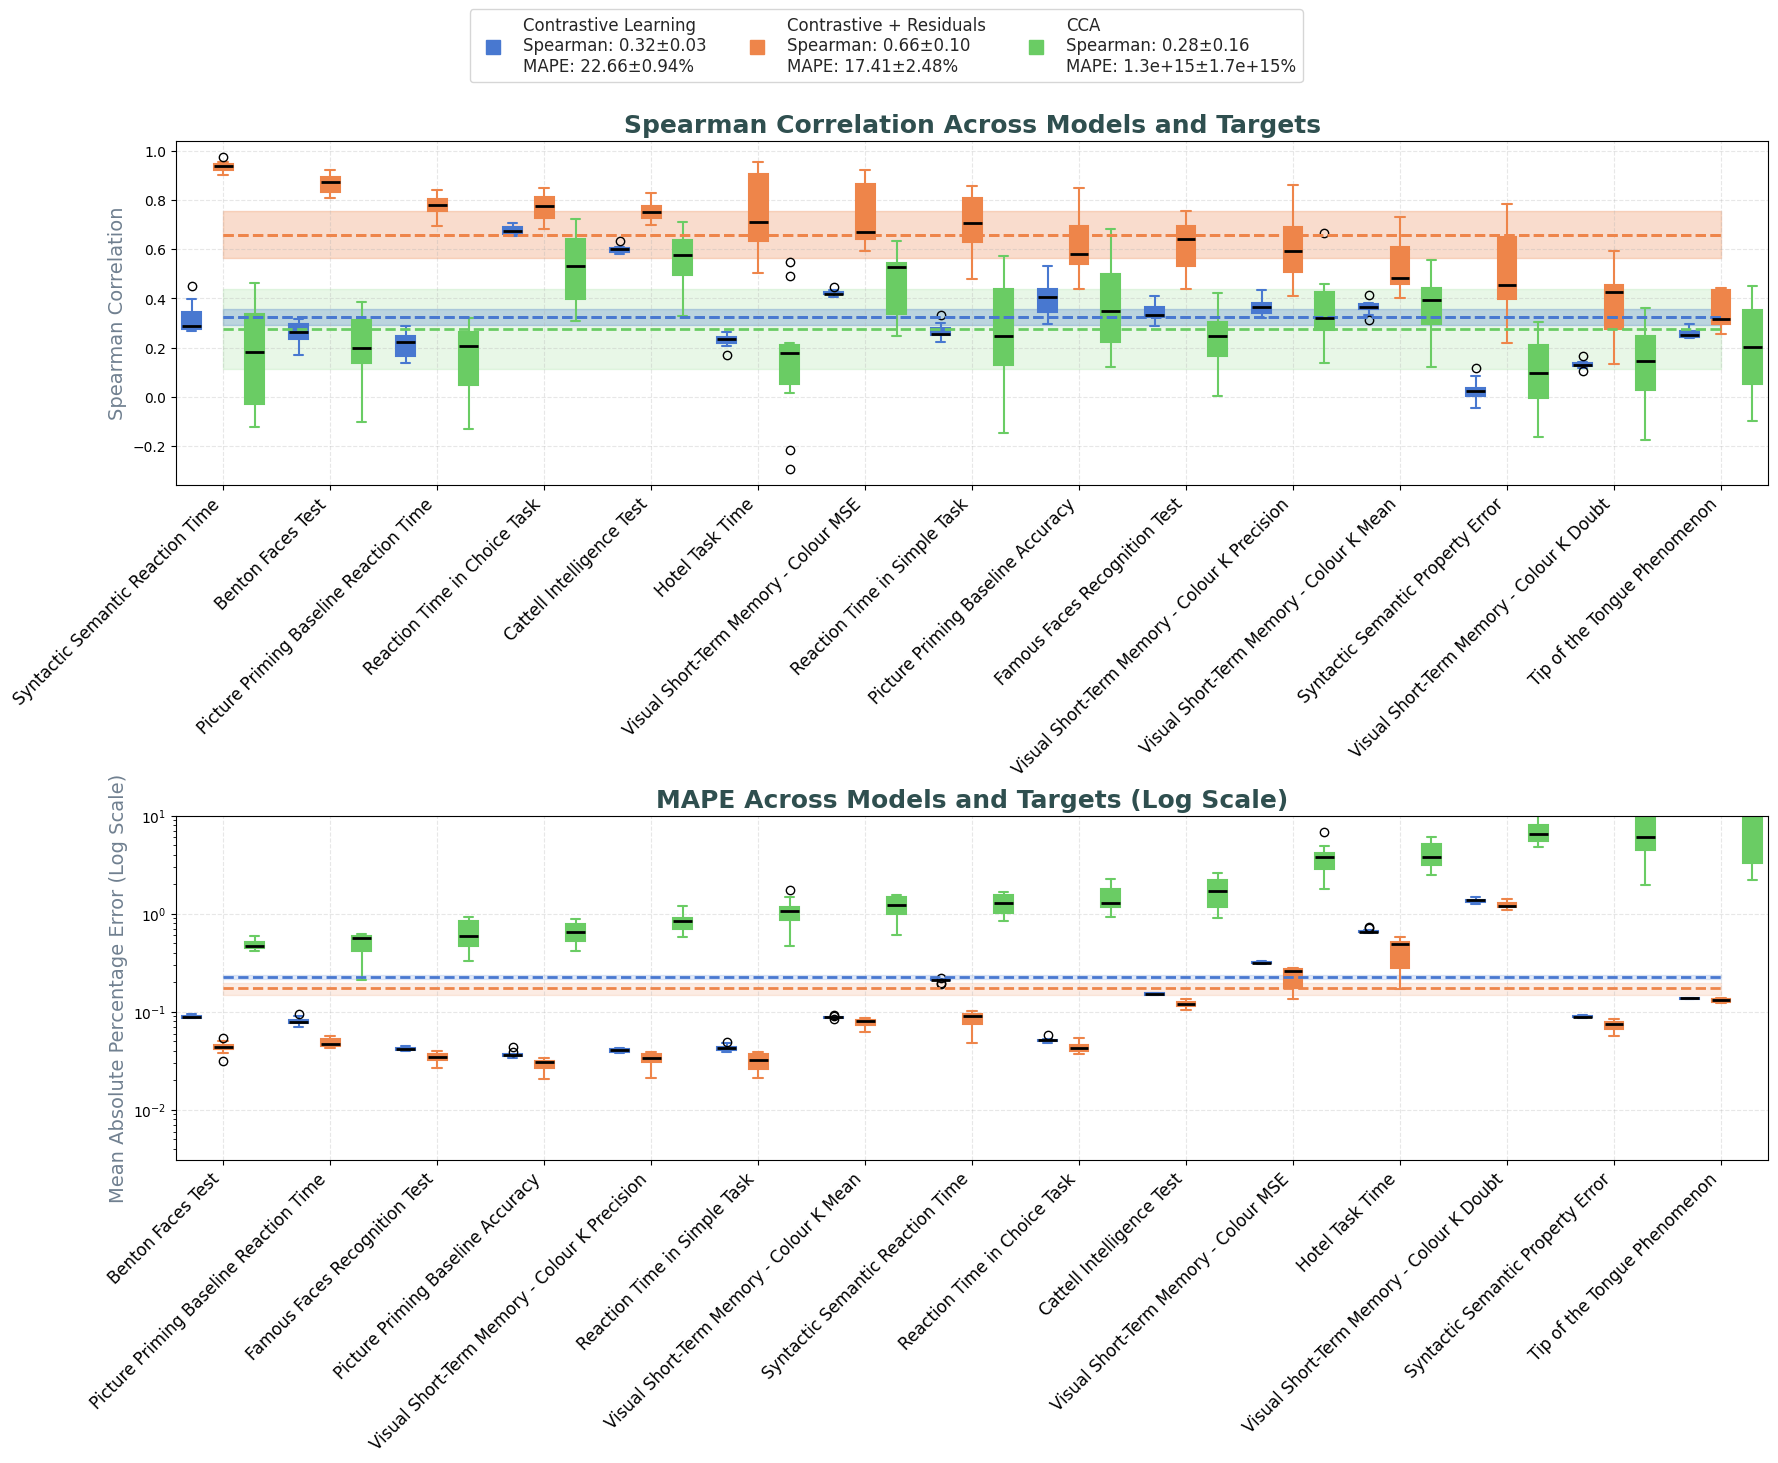

In [15]:
models = ["Contrastive Learning", "Contrastive + Residuals", "CCA"]

plot_boxplots_by_metric(spearman_all_runs, mape_all_runs, 
                            spearman_all_runs_res, mape_all_runs_res,
                            spearman_cca, mape_cca, true_target_names, models)

/tmp/ipykernel_39346/1813828058.py:165: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[1].set_ylim(0, 1e1)


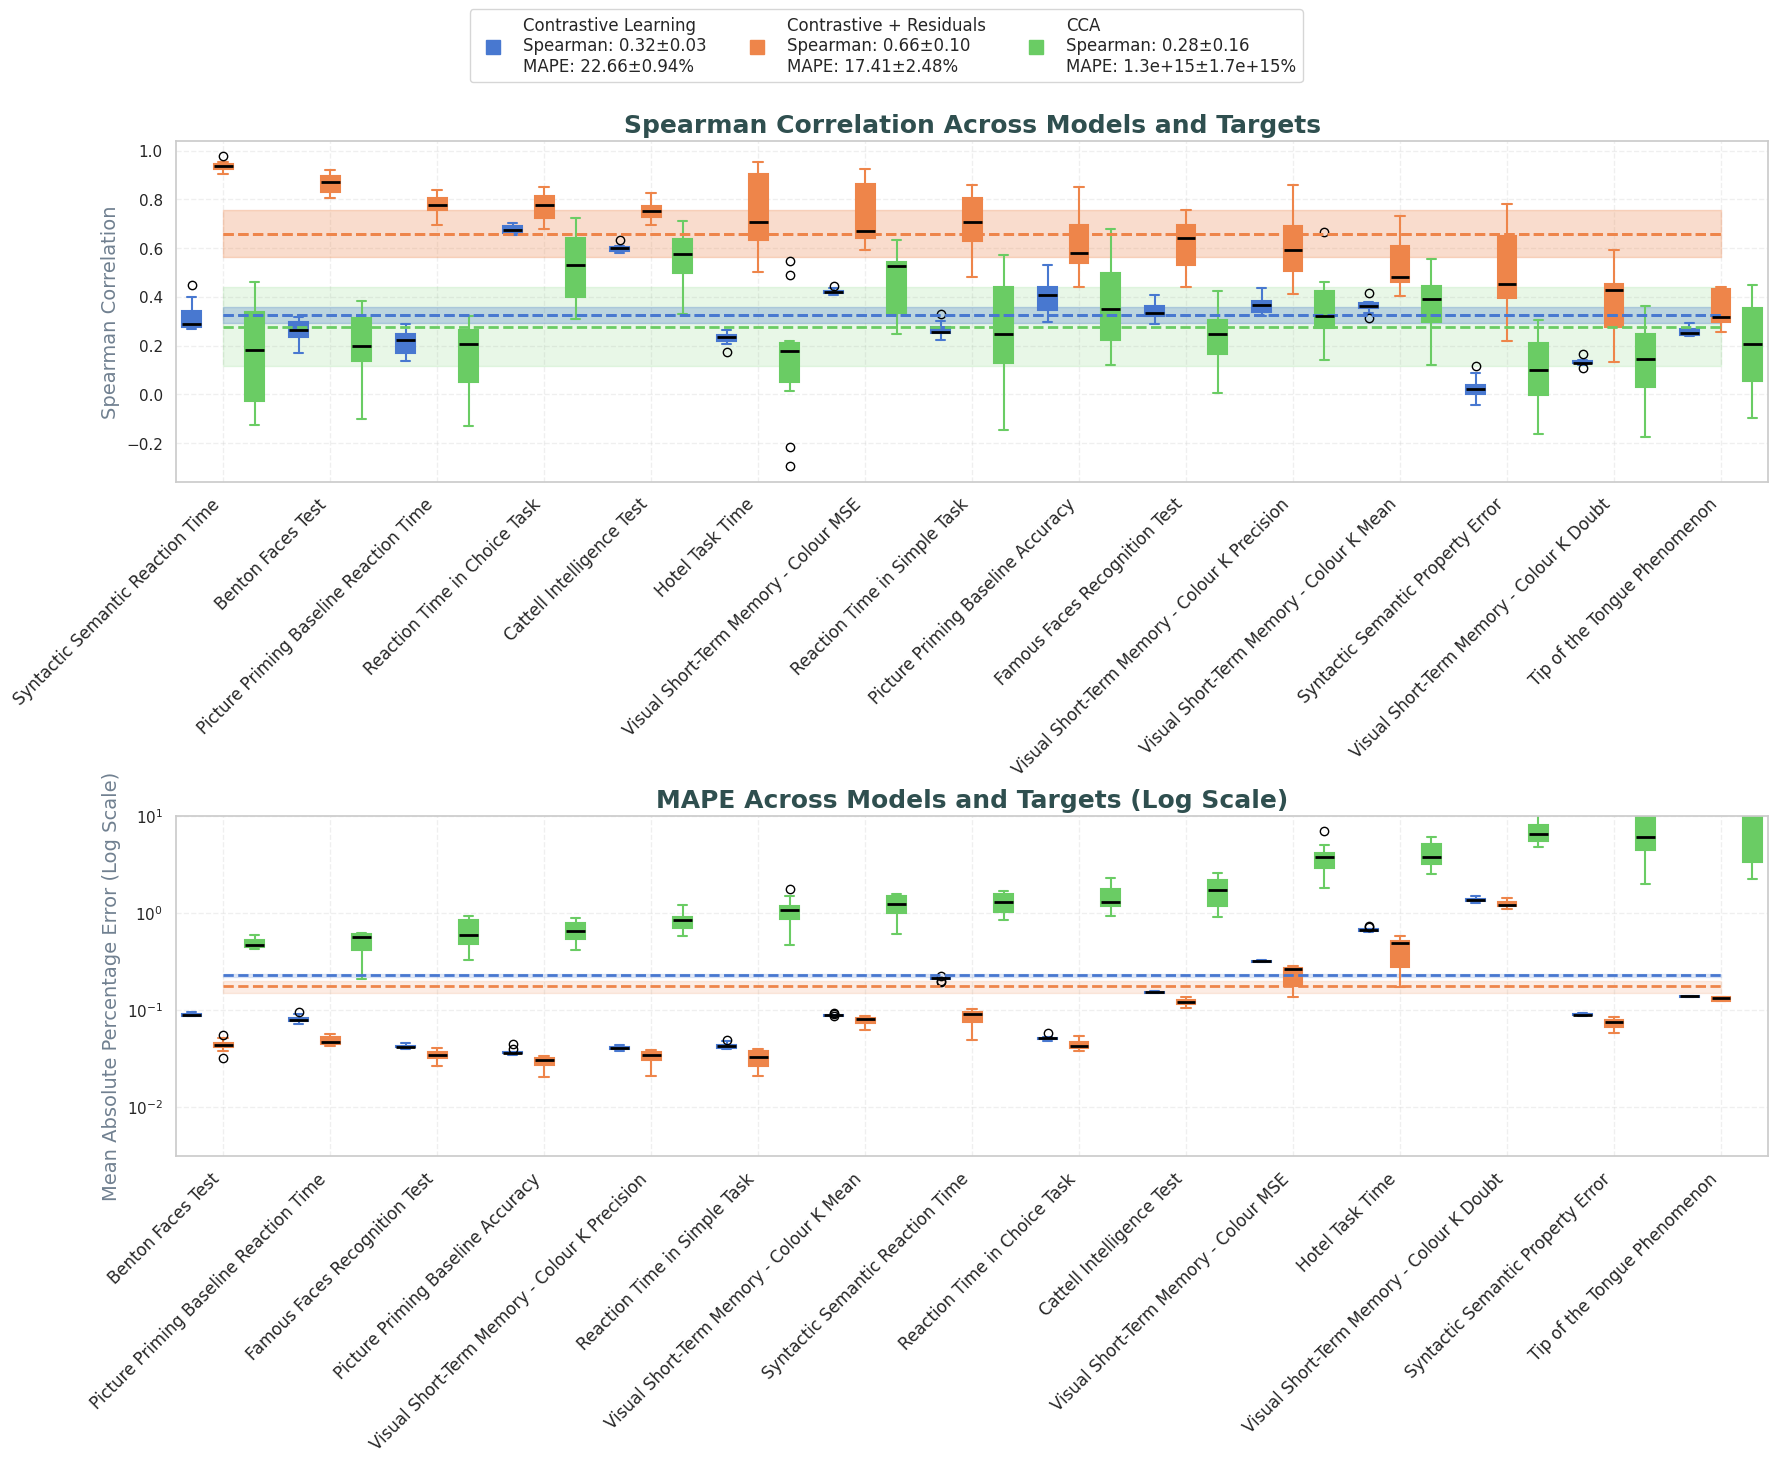

In [16]:
models = ["Contrastive Learning", "Contrastive + Residuals", "CCA"]

plot_boxplots_by_metric(spearman_all_runs, mape_all_runs, 
                            spearman_all_runs_res, mape_all_runs_res,
                            spearman_cca, mape_cca, true_target_names, models)

In [143]:
def plot_boxplots_by_metric_2(spearman_all_runs, mape_all_runs, 
                            spearman_cca, mape_cca, target_names, models):
    """
    Generate box plots for Spearman correlation and MAPE for each target across models.
    """
    
    # Organize data by target across runs
    spearman_data = [
        np.array(spearman_all_runs).T,  # Contrastive Learning
        np.array(spearman_cca).T  # CCA (assumed already per target)
    ]
    mape_data = [
        np.array(mape_all_runs).T*100,  # Contrastive Learning
        np.array(mape_cca).T*100  # CCA (assumed already per target)
    ]

    # Calculate the average score per target across all runs for Spearman and MAPE
    spearman_avg_per_target = [np.mean(model_data, axis=1) for model_data in spearman_data]
    mape_avg_per_target = [np.mean(model_data, axis=1) for model_data in mape_data]

    # Calculate standard deviations across runs for each model (per target)
    std_spearman = [np.std(model_data, axis=1) for model_data in spearman_data]
    std_mape = [np.std(model_data, axis=1) for model_data in mape_data]
    # Rank targets by average Spearman and MAPE scores
    contrastive_index = 0  # Index of 'Contrastive Learning + Residuals' in the models list
    spearman_rank_order = np.argsort(-spearman_avg_per_target[contrastive_index])  # Descending order
    mape_rank_order = np.argsort(mape_avg_per_target[contrastive_index])  # Ascending order

    spearman_data = [data[spearman_rank_order] for data in spearman_data]
    mape_data = [data[mape_rank_order] for data in mape_data]
    target_names_spearman = [target_names[i] for i in spearman_rank_order]
    target_names_mape = [target_names[i] for i in mape_rank_order]
    
    # Calculate the median score and median standard deviation across targets for each model
    # This matches the calculations for the horizontal lines in the plots
    median_scores_spearman = [np.median(model_data) for model_data in spearman_data]
    median_std_spearman = [np.median([np.std(target_scores) for target_scores in model_data]) for model_data in spearman_data]

    median_scores_mape = [np.median(model_data) for model_data in mape_data]
    median_std_mape = [np.median([np.std(target_scores) for target_scores in model_data]) for model_data in mape_data]


    # Sanity check: Ensure all input datasets have the same number of targets
    num_targets = len(target_names)
    if any(len(model_data) != num_targets for model_data in spearman_data + mape_data):
        raise ValueError("All input datasets must have the same number of targets as target_names.")
    
    # Create legend labels with the average and standard deviation of Spearman and MAPE
    custom_legend_labels = []
    for i, model in enumerate(models):
        if model == 'CCA':
            label = (f"{model}\n"
                    f"Spearman: {median_scores_spearman[i]:.2f}±{np.median(median_std_spearman[i]):.2f}\n"
                    f"MAPE: {median_scores_mape[i]:.2f}±{np.median(median_std_mape[i]):.2f}%")
        else :
            label = (f"{model}\n"
                    f"Spearman: {median_scores_spearman[i]:.2f}±{np.median(median_std_spearman[i]):.2f}\n"
                    f"MAPE: {median_scores_mape[i]:.2f}±{np.median(median_std_mape[i]):.2f}%")
            
        custom_legend_labels.append(label)

    # Create custom legend handles
    custom_legend_handles = [
        Line2D([0], [0], color='w', lw=4, label=custom_legend_labels[i], 
               marker='s', markersize=10, markerfacecolor=f"C{i}", markeredgecolor=f"C{i}") 
        for i in range(len(models))
    ]

    # Set up the figure and axes with a minimalist design
    fig, axes = plt.subplots(2, 1, figsize=(18, 14), dpi=100)
    fig.subplots_adjust(hspace=0.4, top=0.5)  # Adjust the top to make space for the legend

    # Set a sleek, modern font for the plot
    plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

    num_models = len(spearman_data)  # Assuming the same number of models for MAPE
    total_boxes_per_axis = num_targets * num_models

    # Set seaborn style with a clean background
    sns.set_theme(style="whitegrid", palette="muted")

    for ax, data, positions_order, plot_title, ylabel in zip(
        axes,
        [spearman_data, mape_data],
        [spearman_rank_order, mape_rank_order],
        ["Spearman Correlation Across Models and Targets", 
         "MAPE Across Models and Targets (%)"],
        ["Spearman Correlation", "Mean Absolute Percentage Error (%)"]
    ):
        # Adjusted positions for each target's group of boxes
        box_positions = np.arange(total_boxes_per_axis)  # Initial positions
        box_spacing = 0.4  # Space between groups of boxes (targets)
        adjusted_positions = [
            np.arange(num_models) + i * (num_models + box_spacing) 
            for i in range(num_targets)
        ]
        
    
        for target_idx, model_pos in enumerate(adjusted_positions):
            for model_idx, model_data in enumerate(data):
                target_scores = model_data[target_idx]
                mean_score = np.median(target_scores)
                std_score = np.std(target_scores)
                
                ax.errorbar(
                    x=model_pos[model_idx],  # Position for this model
                    y=mean_score,  # Mean score
                    yerr=std_score,  # Standard deviation as error
                    color=f"C{model_idx}",  # Color matching the model
                    marker='_', markersize=8,  # Marker for the mean
                    capsize=5,  # Size of the error bar caps
                    elinewidth=1.5,  # Width of the error bar lines
                    capthick=1.5,  # Thickness of the error bar caps
                    linewidth=2  # Width of the line connecting the mean (optional)
                )

        # Add the horizontal lines (average) and blurred regions (mean ± SD)
        for i, (spearman_model_data, mape_model_data) in enumerate(zip(spearman_data, mape_data)):
            # if models[i] == "CCA" and ax == axes[1]:  # If CCA model and we're plotting MAPE
            #     continue
            # Spearman Plot: mean ± std for each model
            spearman_mean = np.median(spearman_model_data)
            spearman_avg_std = np.median([np.std(target_scores) for target_scores in spearman_model_data])

            # MAPE Plot: mean ± std for each model
            mape_mean = np.median(mape_model_data)
            mape_avg_std = np.median([np.std(target_scores) for target_scores in mape_model_data])

            # Common x positions for both plots (center of each target's group)
            x_positions = [pos[num_models // 2] for pos in adjusted_positions]
            x_positions[0]= x_positions[0]-2
            x_positions[-1]=x_positions[-1]+2
            #Spearman mean and standard deviation lines
            axes[0].plot(
                x_positions, 
                [spearman_mean] * num_targets,  
                color=f"C{i}", lw=2, linestyle="--", label=f"{models[i]} Mean" if i == 0 else None  # Dotted line for the mean
            )
            axes[0].fill_between(
                x_positions, 
                spearman_mean - spearman_avg_std,  # Mean ± std
                spearman_mean + spearman_avg_std,
                color=f"C{i}", alpha=0.15  # Subtle blurred region for ± avg std
            )
            if ax == axes[1]:
                # MAPE mean and standard deviation lines
                axes[1].plot(
                    x_positions,  
                    [mape_mean] * num_targets,  
                    color=f"C{i}", lw=2, linestyle="--", label=f"{models[i]} Mean" if i == 0 else None  # Dotted line for the mean
                )
                axes[1].fill_between(
                    x_positions,  
                    mape_mean - mape_avg_std,  # Mean ± std
                    mape_mean + mape_avg_std, 
                    color=f"C{i}", alpha=0.15  # Subtle blurred region for ± avg std
                )

        # Adjust xticks and labels
        ax.set_xticks([pos[num_models // 2] for pos in adjusted_positions])
        ax.set_xticklabels(target_names_spearman if ax == axes[0] else target_names_mape, 
                           rotation=0, ha="right", fontsize=16)
        midpoints = [(adjusted_positions[i][-1] + adjusted_positions[i+1][0]) / 2 
             for i in range(num_targets - 1)]

        # Add vertical grid lines at midpoints (between target groups)
        ax.grid(True, linestyle='-', alpha=0.3, axis='y')  # This line remains the same for horizontal grid lines
        ax.vlines(midpoints, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
                linestyles='-', alpha=0.3, colors='gray')
        ax.set_title(plot_title, fontsize=18, fontweight="bold", color="darkslategray")
        ax.set_ylabel(ylabel, fontsize=14, color="slategray")
        #ax.grid(True, linestyle='--', alpha=0.3, axis = 'y')
        # ax.grid(False)
        ax.grid(True, axis='x', linestyle='--', alpha=0)
    #axes[1].set_yscale("log")
    axes[1].set_ylim(0, 150)
    # Add custom legend at the top
    fig.legend(handles=custom_legend_handles, loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 1.05))

    # Final design tweaks and visualization
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust again to ensure legend is properly placed
    plt.show()


In [141]:
true_target_names = [
    "Benton Faces Test", "Cattell Intelligence Test", "Famous Faces Recognition Test", "Hotel Task Time", 
    "Picture Priming Baseline Accuracy", "Picture Priming Baseline Reaction Time", 
    "Reaction Time in Choice Task", "Reaction Time in Simple Task", "Syntactic Semantic Property Error", 
    "Syntactic Semantic Reaction Time", "Tip of the Tongue Phenomenon", 
    "Visual Short-Term Memory - Colour K Mean", "Visual Short-Term Memory - Colour K Precision", 
    "Visual Short-Term Memory - Colour K Doubt", "Visual Short-Term Memory - Colour MSE"
]
numbered_targets = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

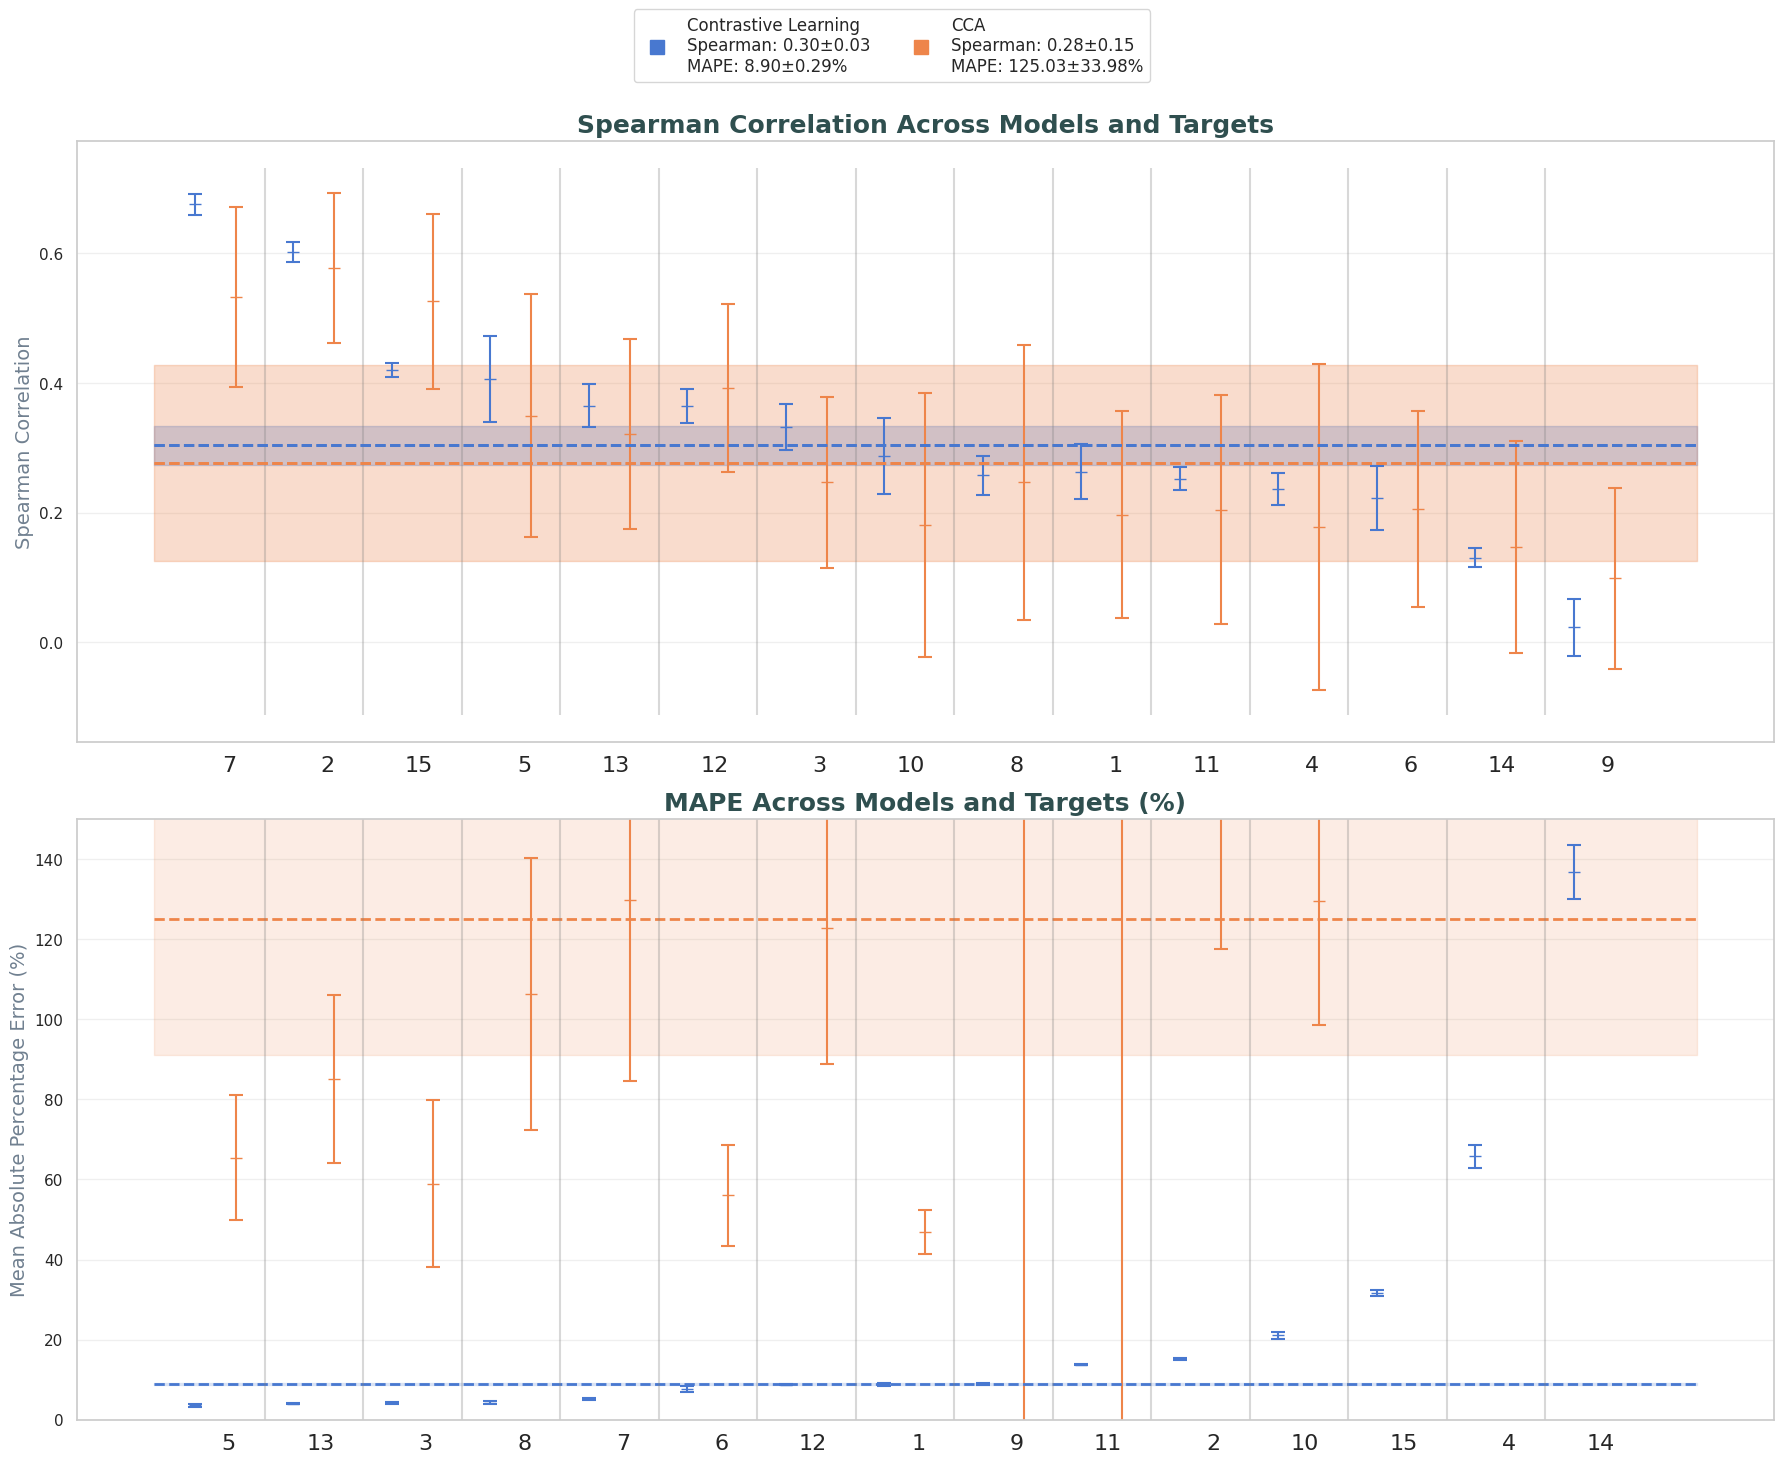

In [144]:
models = ["Contrastive Learning", "CCA"]

plot_boxplots_by_metric_2(spearman_all_runs, mape_all_runs, 
                            spearman_cca, mape_cca, numbered_targets, models)